In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import mlflow
import matplotlib.pyplot as plt
import utils.metrics as metrics
from regions import pacific_nw_inland
from datasource import NoaaLivnehDataLoader
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tqdm import tqdm

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = NoaaLivnehDataLoader(gcs_bucket='noaa-livneh', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# NOAA 20th century reanalysis
noaa = xr.open_zarr(data.noaa20cr(), consolidated=True).clip(min=0.0, max=np.inf)
livneh16 = xr.open_zarr(data.livneh(), consolidated=True).clip(min=0.0, max=np.inf)
def get_train_test_splits(data_lo, data_hi, region_fn, scale):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
    lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
    hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    return lr_train, lr_test, hr_train, hr_test

def upscale(data, factor=2):
    lat = data.lat
    lon = data.lon
    data = data.chunk({'lat': lat.size, 'lon': lon.size})
    return data.interp({'lat': lat[::2], 'lon': lon[::2]}, method='linear')

def preprocess_noaa(ds, var, time_st='2000-01-01', time_en='2013-12-31'):
    noaa_pnw = pacific_nw_inland(ds).sel(time=slice(time_st, time_en))
    return noaa_pnw[var].load()

def preprocess_livneh(ds, var, upscale_factor=2, time_st='1987-01-01', time_en='1999-12-31'):
    livneh16_pnw = pacific_nw_inland(livneh16, scale_factor=16, lon_west=True).sel(time=slice(time_st, time_en))
    livneh_pnw = upscale(livneh16_pnw, factor=upscale_factor)
    livneh_pnw = livneh_pnw.interpolate_na(dim='lat')
    return livneh_pnw[var].load()

In [4]:
noaa_pnw_maxt = preprocess_noaa(noaa, 'tasmax')
livneh_pnw_maxt = preprocess_livneh(livneh16, 'tasmax')
noaa_pnw_pr = preprocess_noaa(noaa, 'pr')
livneh_pnw_pr = preprocess_livneh(livneh16, 'pr')

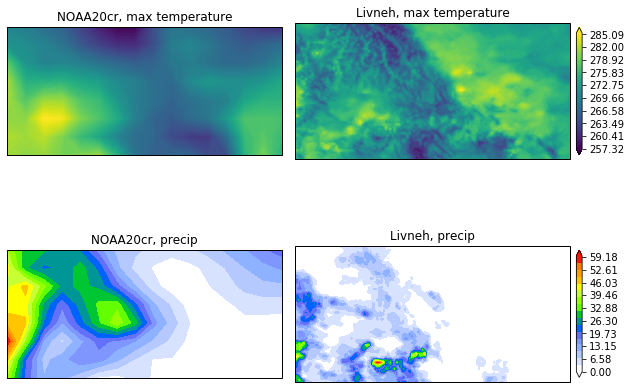

In [5]:
fig, axs, plot_fn = image_map_factory(2, 2, figsize=(6,4))
plot_fn(axs[0,0], noaa_pnw_maxt[0], noaa_pnw_pr.lat, noaa_pnw_pr.lon, title='NOAA20cr, max temperature', cmap='viridis')
cs = plot_fn(axs[0,1], livneh_pnw_maxt[0], livneh_pnw_pr.lat, livneh_pnw_pr.lon, title='Livneh, max temperature', cmap='viridis')
fig.colorbar(cs, ax=axs[0,:].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01)
plot_fn(axs[1,0], noaa_pnw_pr[0], noaa_pnw_pr.lat, noaa_pnw_pr.lon, title='NOAA20cr, precip', cmap=prcp_cmap())
cs = plot_fn(axs[1,1], livneh_pnw_pr[0], livneh_pnw_pr.lat, livneh_pnw_pr.lon, title='Livneh, precip', cmap=prcp_cmap())
fig.colorbar(cs, ax=axs[1,:].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01)

In [13]:
def plot_1xn(data, title, cmin=-10., cmax=10., cmap='viridis'):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(data[i].numpy().squeeze(), origin='lower', cmap=cmap)
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.suptitle(title, y=0.85)
    plt.show()

def upsample(new_wt, new_ht, method, scale_factor=1):
    @tf.function
    def _upsample(x):
        return tf.image.resize(x, (new_wt,new_ht), method=method) / scale_factor
    return _upsample

def spatial_mae(scale, stride=1):
    """
    "Spatial" MAE auxiliary loss for generator. Penalizes outputs
    which violate spatial average preservation between input and output.
    """
    kernel = tf.ones((scale,scale,1,1)) / (scale**2.)
    def _spatial_mse(x_in, y_pred):
        x_avg = tf.nn.conv2d(x_in, kernel, strides=(stride, stride), padding='VALID')
        y_avg = tf.nn.conv2d(y_pred, kernel, strides=(stride, stride), padding='VALID')
        return tf.math.reduce_mean(tf.math.abs(y_avg - x_avg))
    return _spatial_mse

def fit_glow_jflvm_maxt(train_lr, train_hr, test_hr, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                        layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, lam_decay=0.0, alpha=1.0):
    from normalizing_flows.models import JointFlowLVM, adversarial
    from normalizing_flows.flows import Transform, Flow, Invert
    from normalizing_flows.flows.image import Upsample
    from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
    train_lr = train_lr.expand_dims(chan=1, axis=-1)
    train_hr = train_hr.expand_dims(chan=1, axis=-1)
    test_hr = test_hr.expand_dims(chan=1, axis=-1)
    N_train = train_hr.shape[0]
    N_test = test_hr.shape[0]
    (wt, ht), (wt_hi, ht_hi) = train_lr.shape[1:3], train_hr.shape[1:3]
    scale = wt_hi // wt
    train_lo, monthly_means_lo = remove_monthly_means(train_lr, time_dim='time')
    train_hi, monthly_means_hr = remove_monthly_means(train_hr, time_dim='time')
    test_hi,_ = remove_monthly_means(test_hr, monthly_means_hr, time_dim='time')
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR)).shuffle(load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size).shuffle(load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size).shuffle(load_batch_size)
    train_ds = tf.data.Dataset.zip((train_lo_ds, train_hi_ds)).batch(sample_batch_size)
    test_ds = tf.data.Dataset.zip((train_lo_ds, test_hi_ds)).batch(sample_batch_size)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_hr'))
    flow_lr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_lr'))
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy,
                               Gx_aux_loss=spatial_mae(scale, stride=scale),
                               Gy_aux_loss=spatial_mae(scale),
                               input_shape=(None,wt_hi,ht_hi,1))
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam-lam_decay*validate_freq*i, lam_decay=lam_decay, alpha=alpha)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        model_joint.save('data/saved_models/glow-jflvm/noaa_livneh/maxt/ckpt')
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$")
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$")
        x_t, y_t = next(test_ds.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$")
        y_true, y_pred = [], []
        for x, y in test_ds.take(100):
            y_true.append(y)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        rmse = tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
        mlflow.log_metric('rmse', tf.math.reduce_mean(rmse).numpy())
        plt.figure(figsize=(2*8,6))
        plt.plot(range(rmse.shape[0]), rmse, c='g')
        plt.title('Validation RMSE vs time')
        plt.show()
    return model_joint

In [7]:
livneh_pnw_maxt_test = preprocess_livneh(livneh16, 'tasmax', time_st='2000-01-01', time_en='2013-12-31')

Training joint model for 10 epochs (0/100 complete)


eval: 100%|██████████| 511/511 [01:51<00:00,  4.57it/s, nll_x=0.794, nll_y=1.68, gx_loss=-1.18, gy_loss=2.58, dx_loss=-.376, dy_loss=-.779, gx_aux=0.164, gy_aux=0.16] 


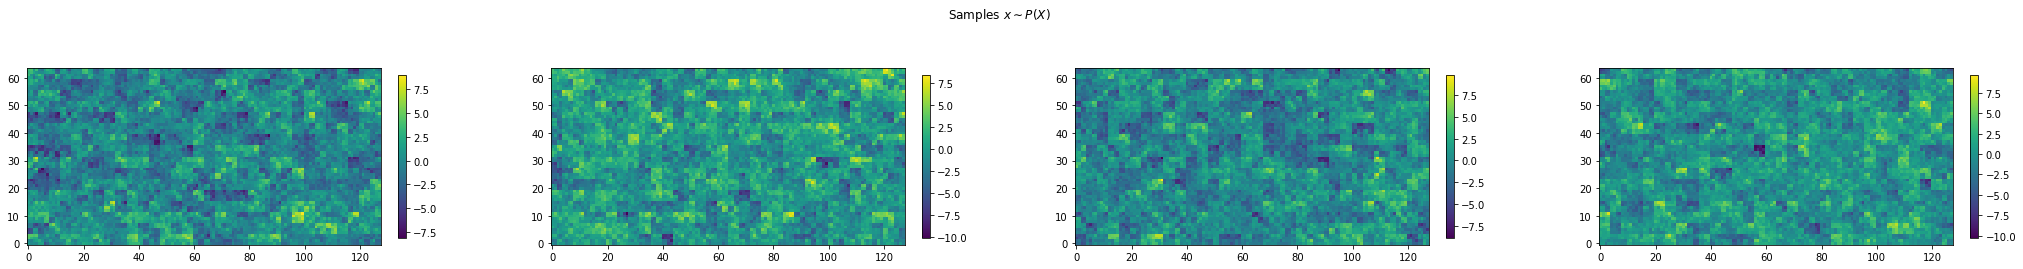

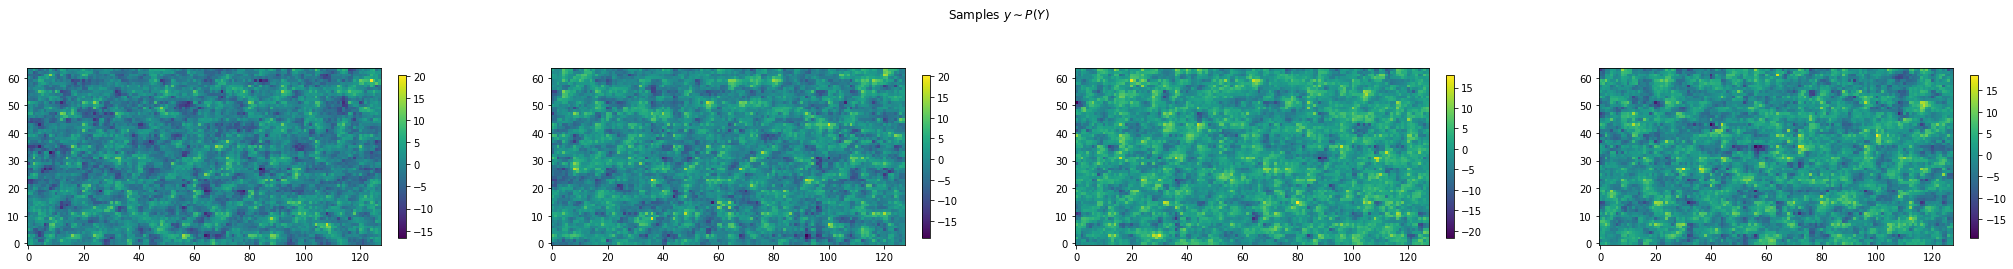

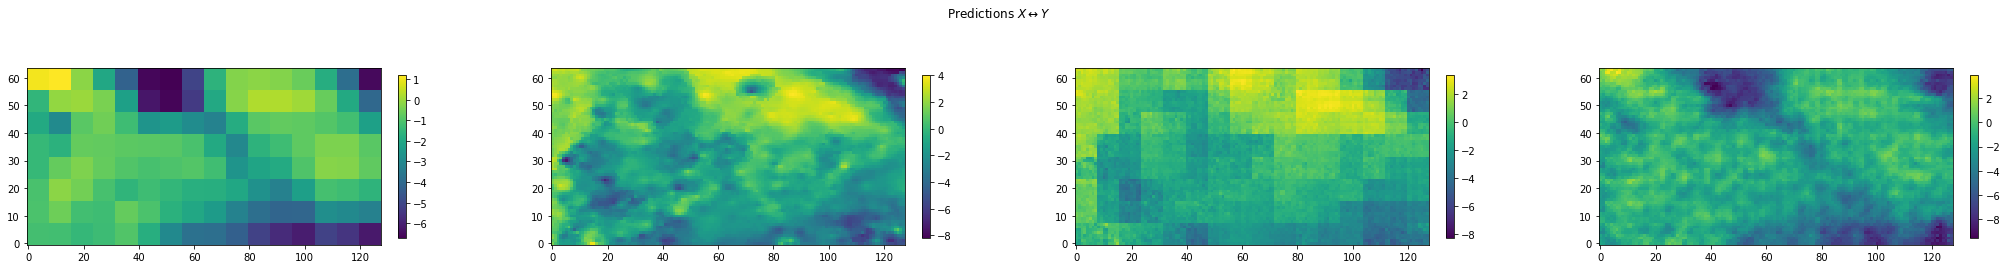

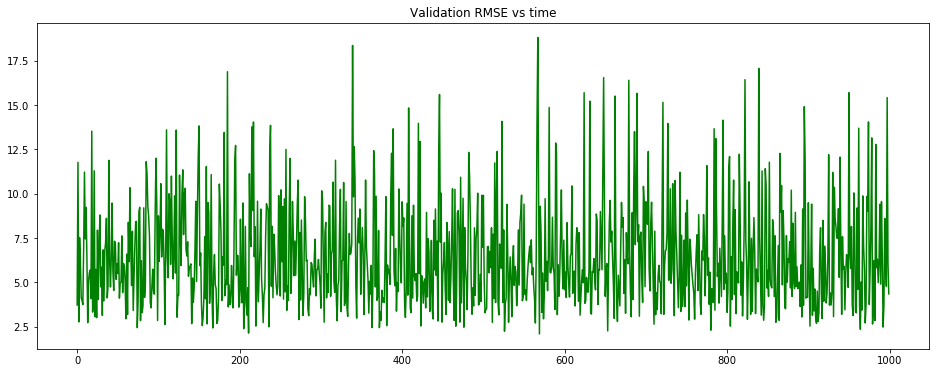

Training joint model for 10 epochs (10/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.22it/s, nll_x=-.547, nll_y=1.06, gx_loss=-4.7, gy_loss=6.73, dx_loss=-.695, dy_loss=-.642, gx_aux=0.191, gy_aux=0.341] 


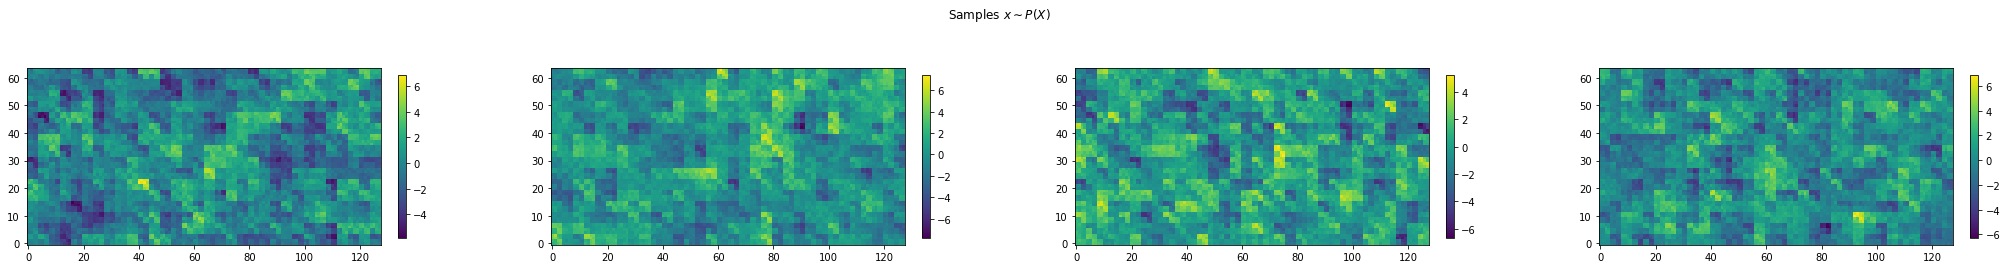

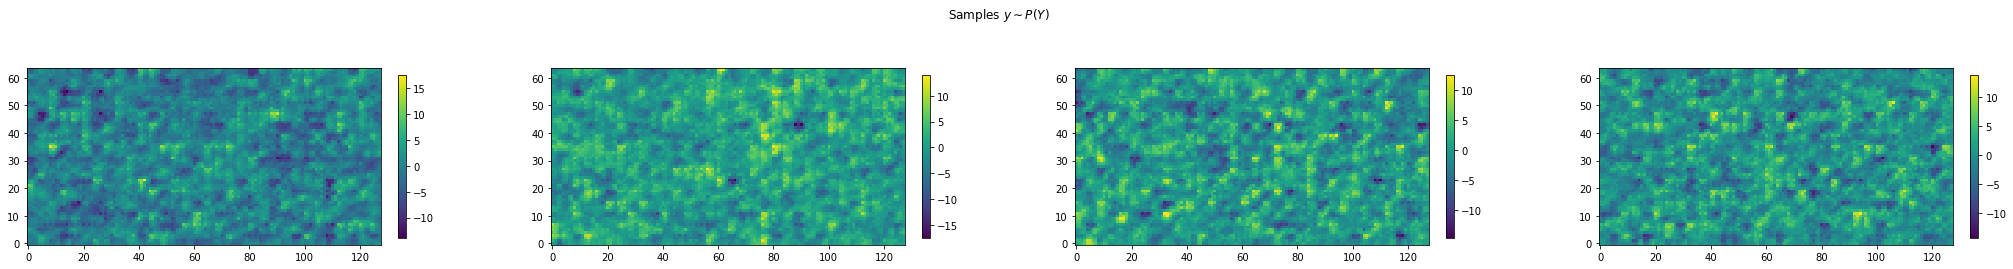

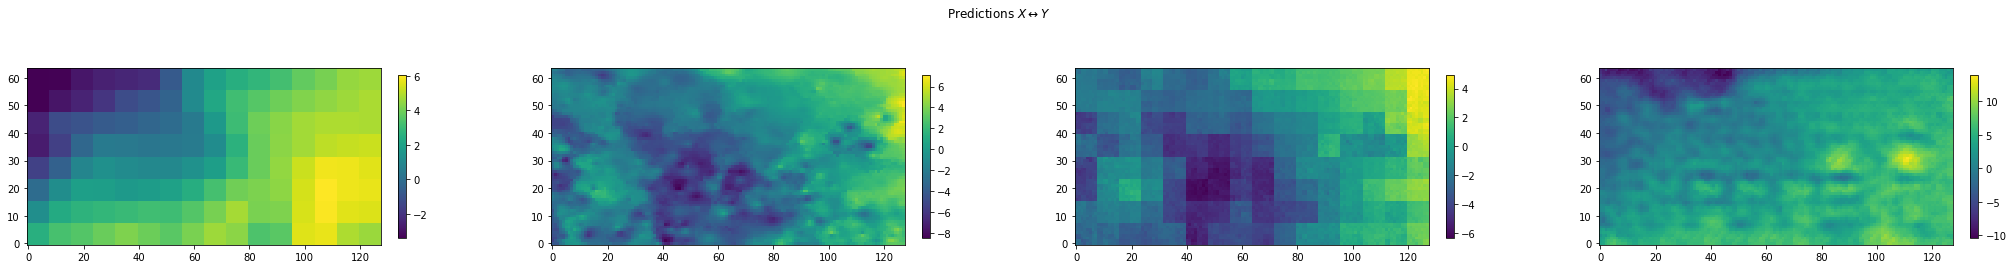

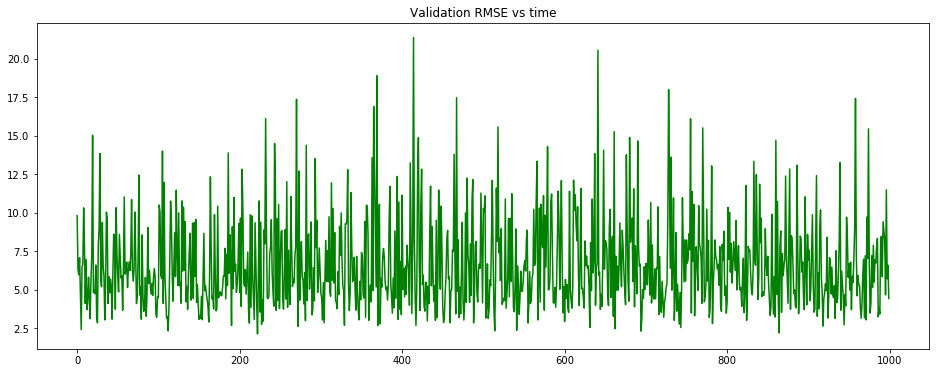

Training joint model for 10 epochs (20/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.27it/s, nll_x=-1.62, nll_y=0.745, gx_loss=-8.2, gy_loss=10.1, dx_loss=-.746, dy_loss=-.67, gx_aux=0.193, gy_aux=0.347]  


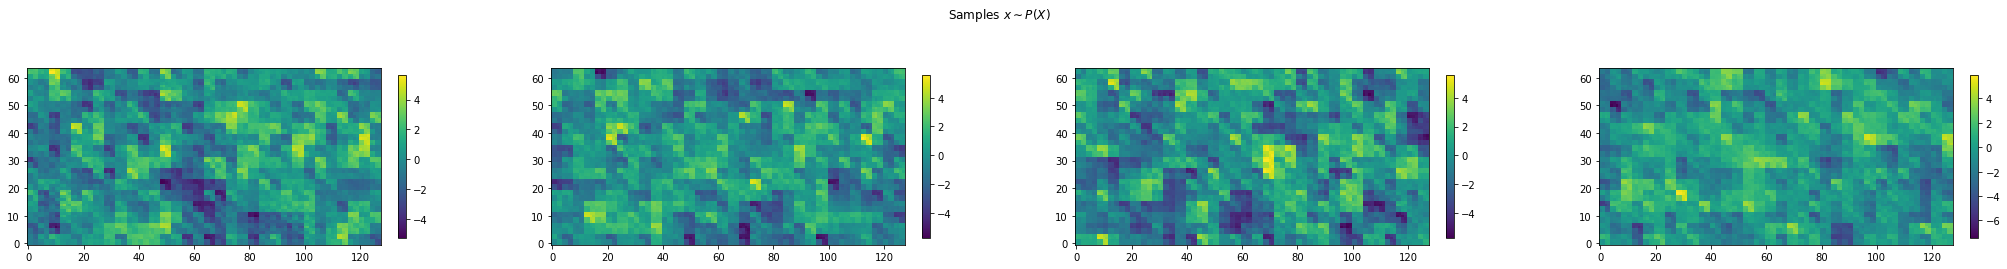

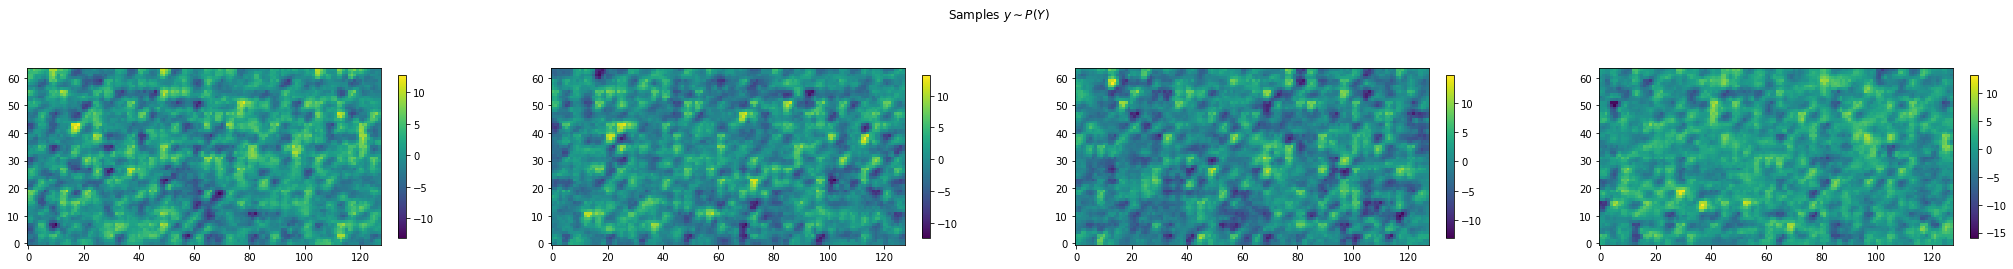

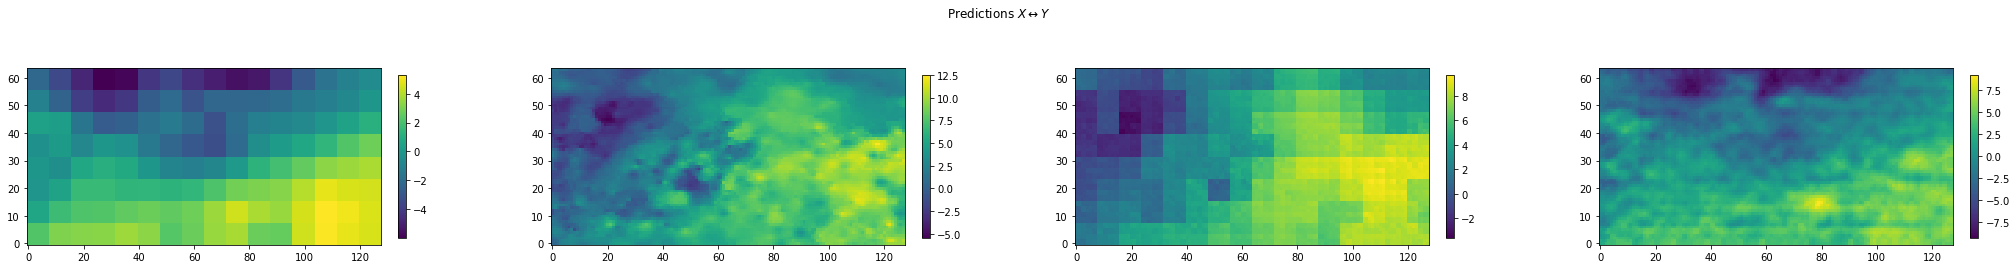

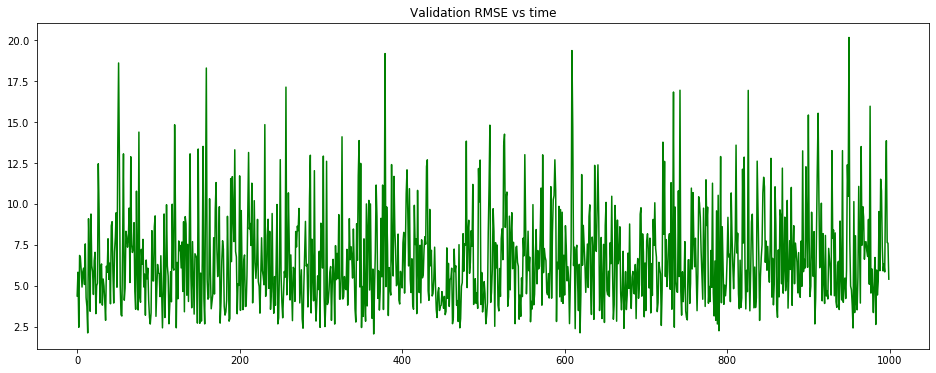

Training joint model for 10 epochs (30/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.25it/s, nll_x=-2.51, nll_y=0.628, gx_loss=-11.2, gy_loss=12.9, dx_loss=-.55, dy_loss=-.651, gx_aux=0.421, gy_aux=0.372] 


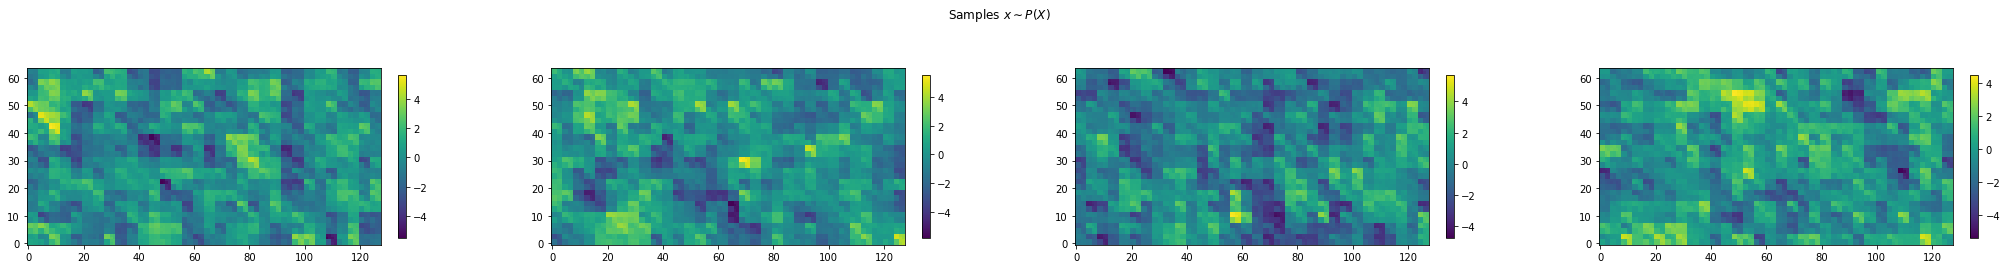

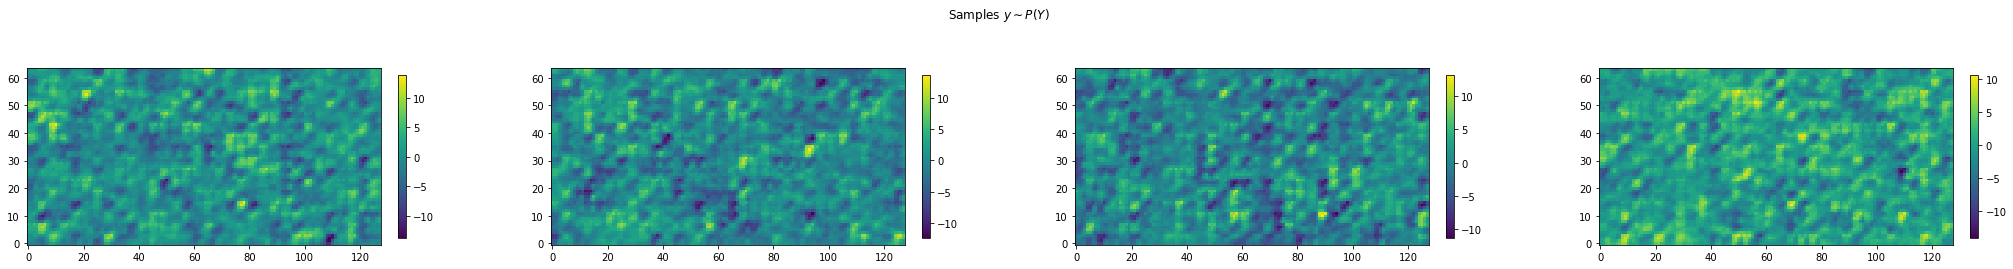

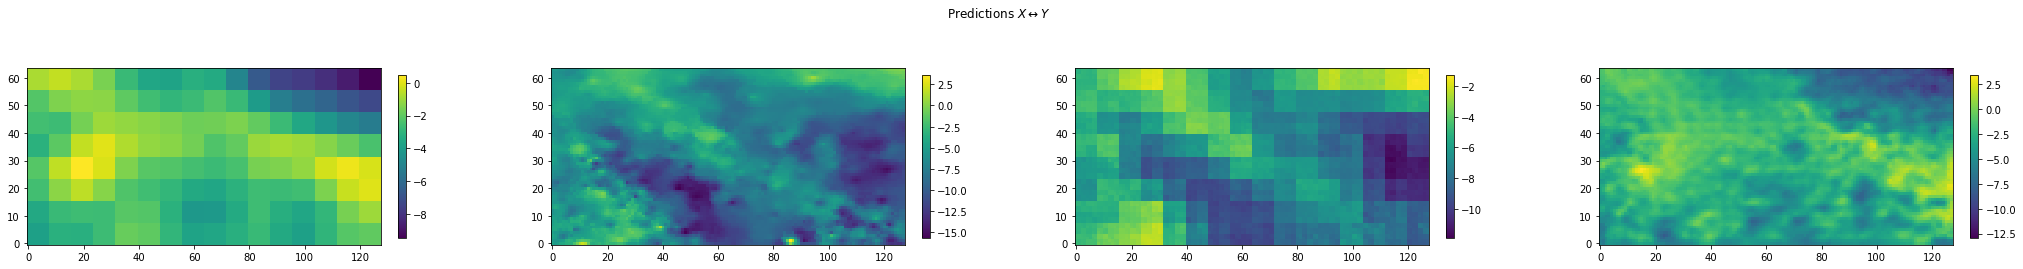

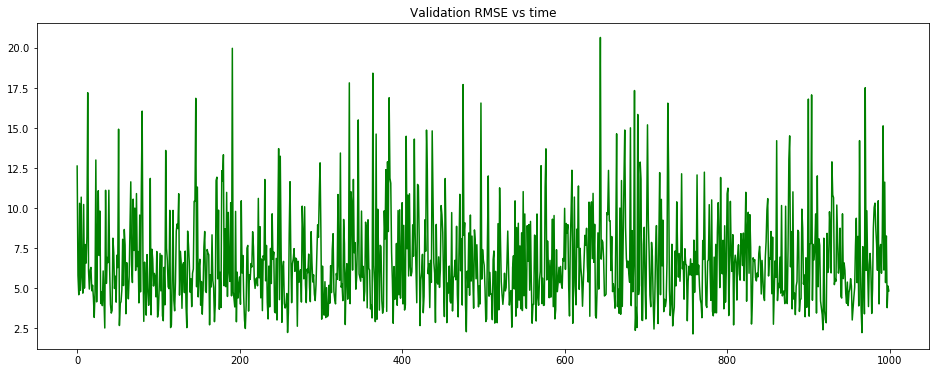

Training joint model for 10 epochs (40/100 complete)


eval: 100%|██████████| 511/511 [01:11<00:00,  7.20it/s, nll_x=-2.98, nll_y=0.586, gx_loss=-12.7, gy_loss=15, dx_loss=-.569, dy_loss=-.152, gx_aux=0.385, gy_aux=0.873] 


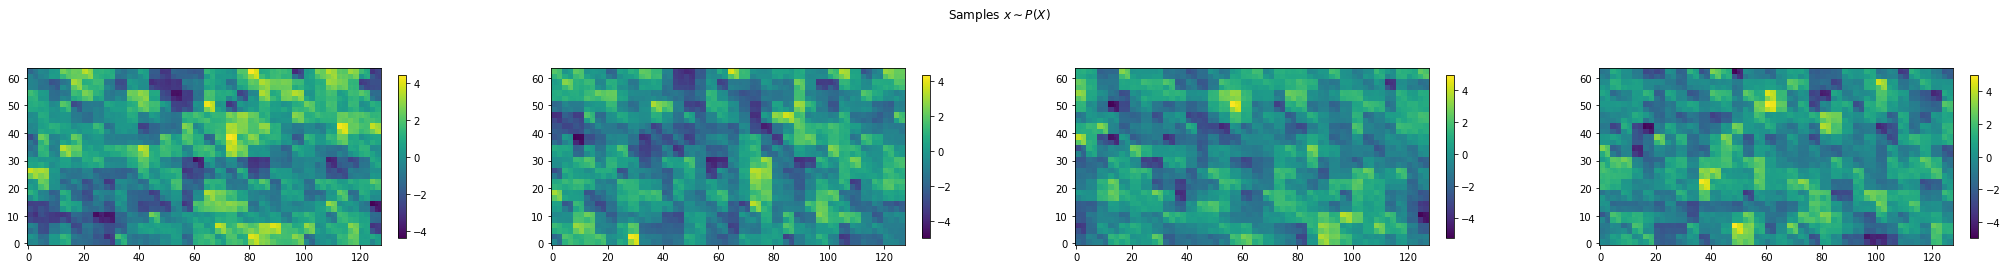

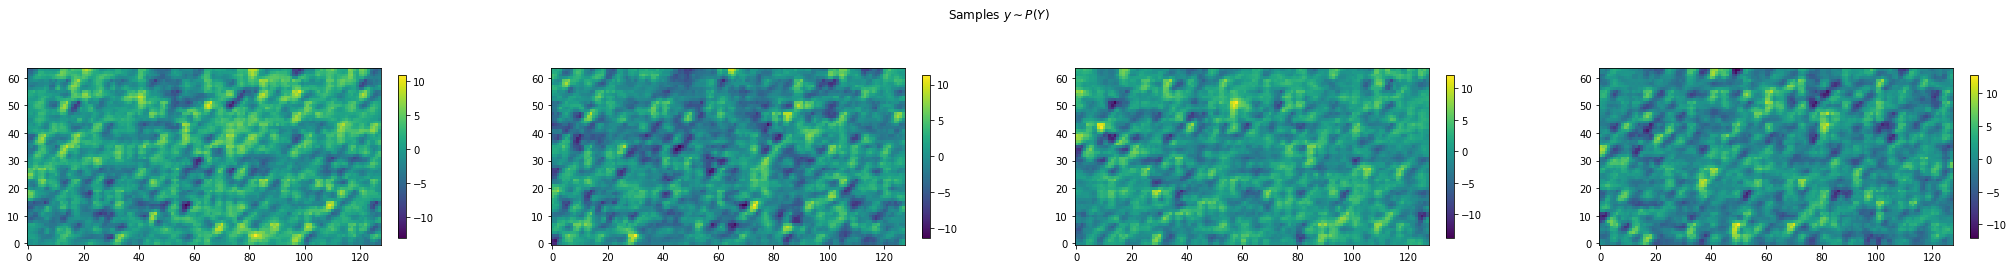

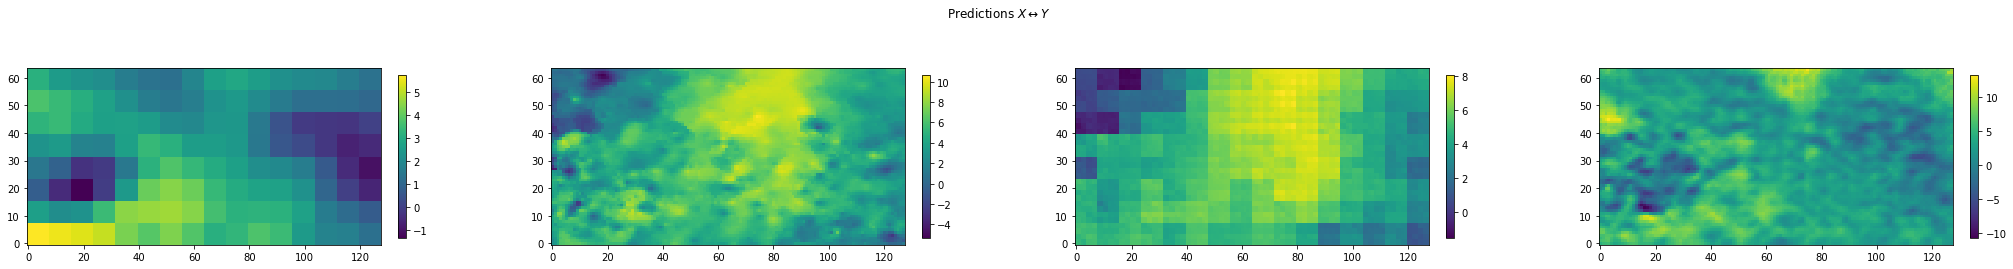

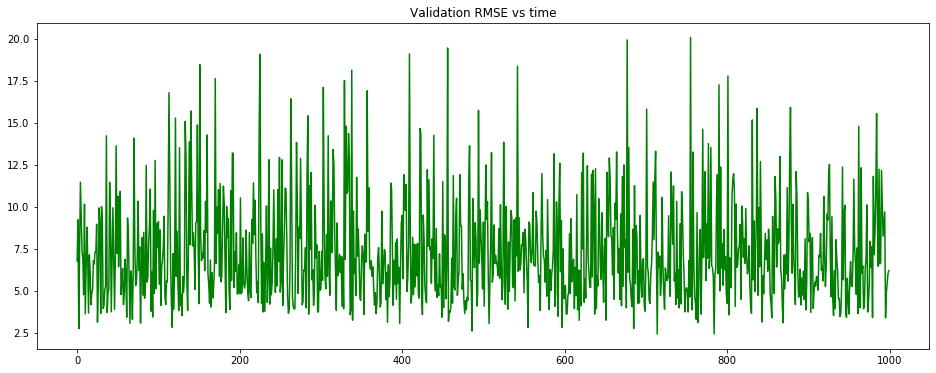

Training joint model for 10 epochs (50/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.34it/s, nll_x=-3.56, nll_y=0.547, gx_loss=-14.3, gy_loss=17.3, dx_loss=-.598, dy_loss=-.468, gx_aux=0.313, gy_aux=0.493]


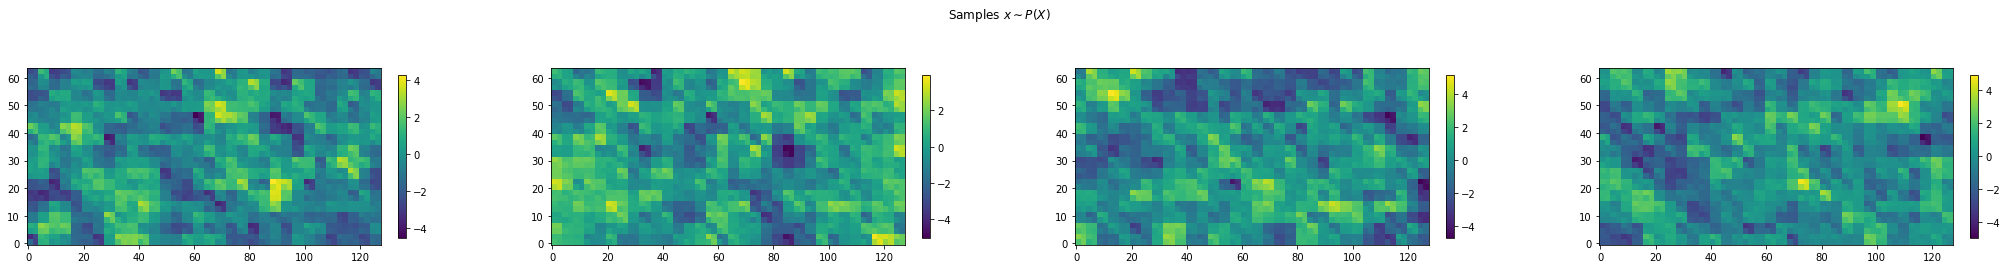

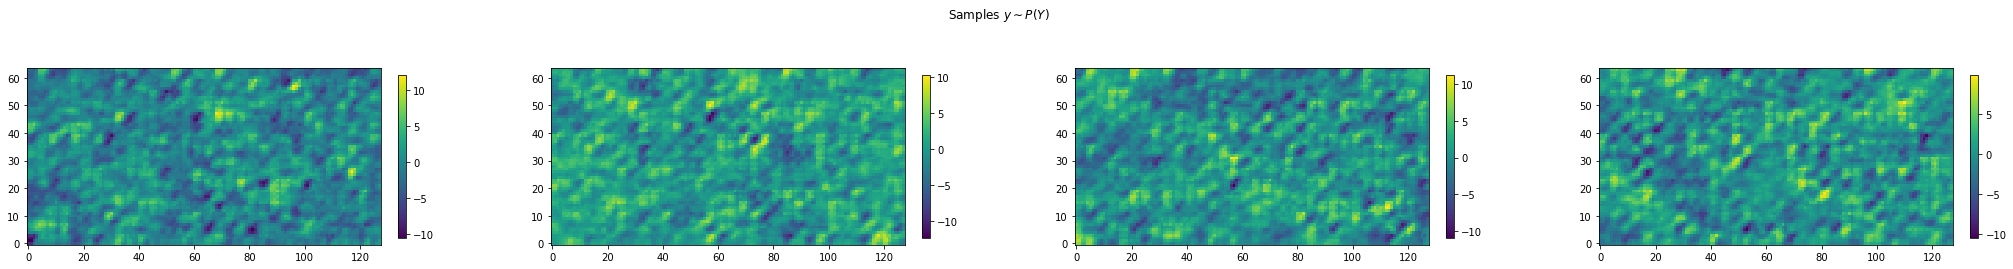

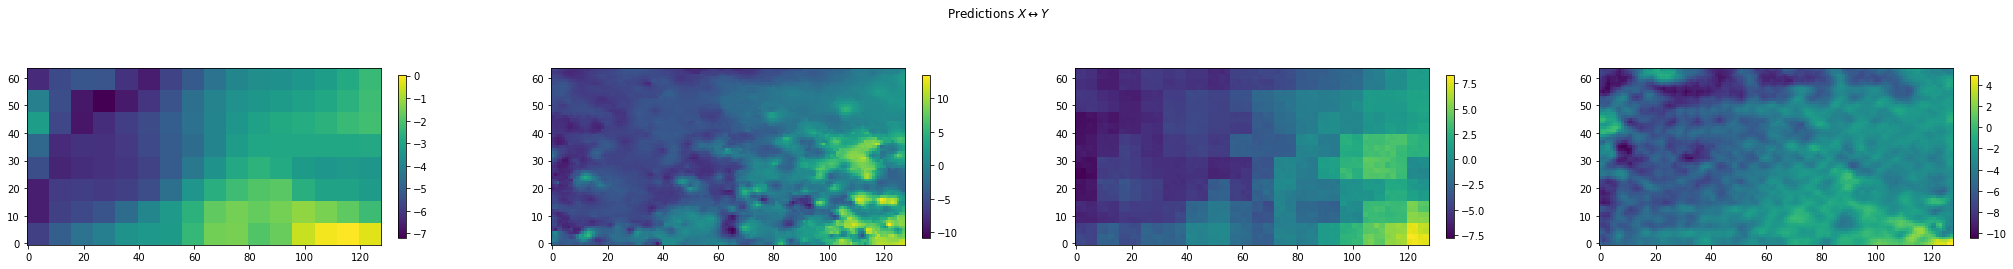

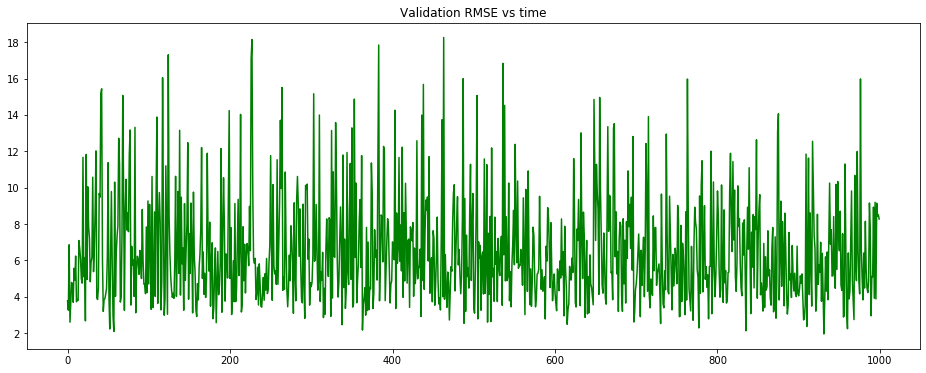

Training joint model for 10 epochs (60/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.34it/s, nll_x=-3.68, nll_y=0.523, gx_loss=-15.8, gy_loss=19.3, dx_loss=-.697, dy_loss=-.731, gx_aux=0.266, gy_aux=0.291]


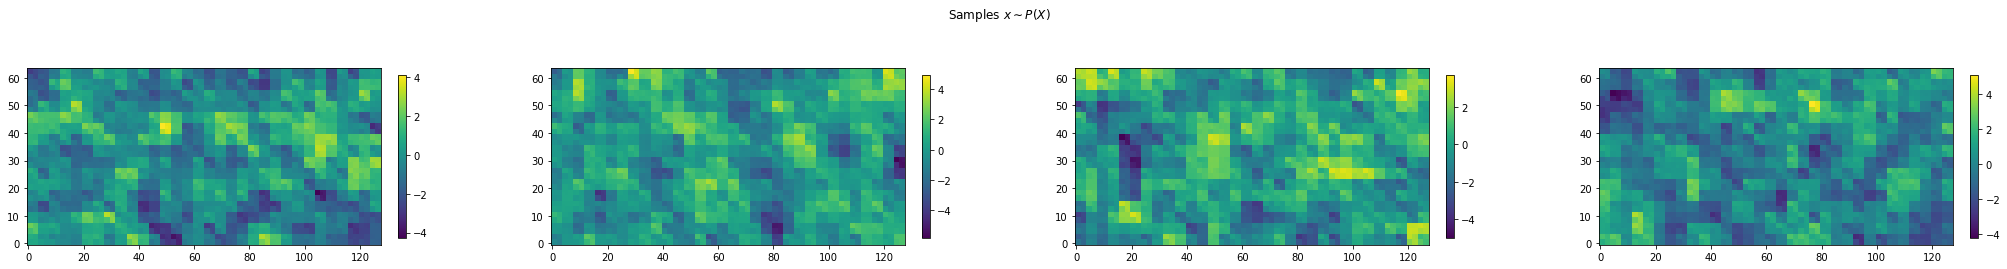

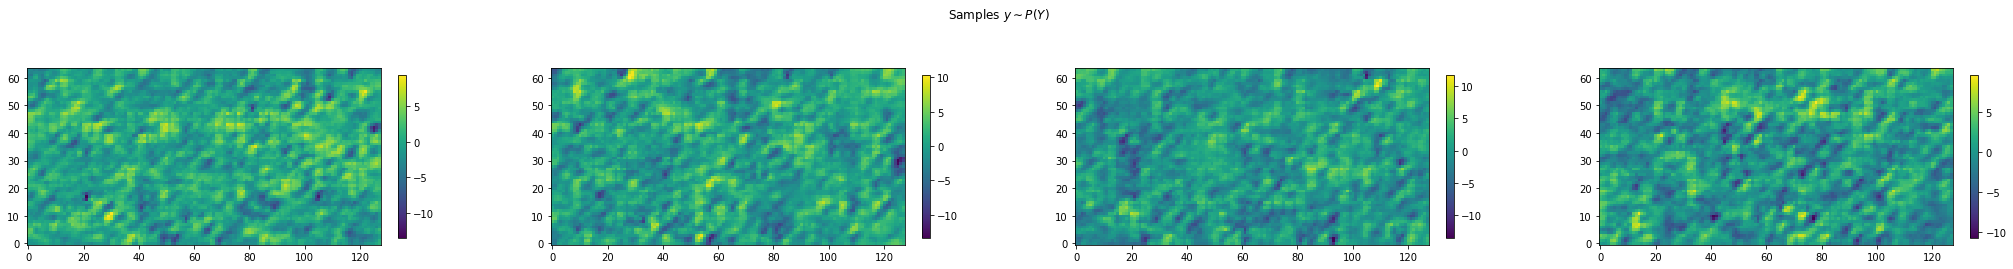

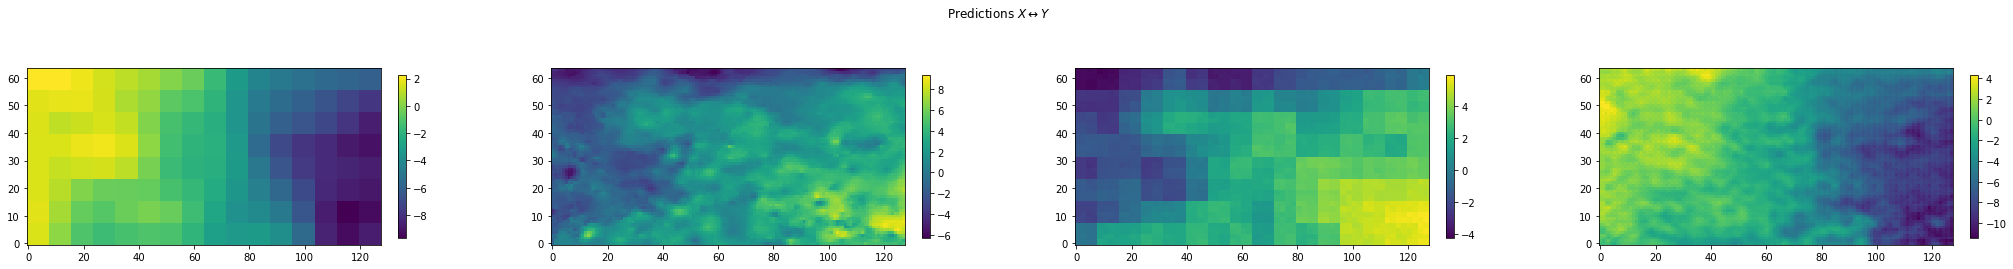

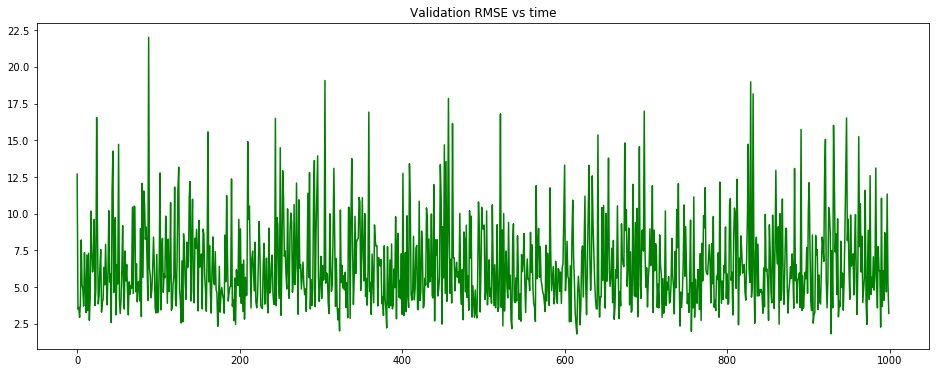

Training joint model for 10 epochs (70/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.30it/s, nll_x=-4.03, nll_y=0.499, gx_loss=-17.6, gy_loss=21.6, dx_loss=-.369, dy_loss=-.431, gx_aux=0.596, gy_aux=0.598]


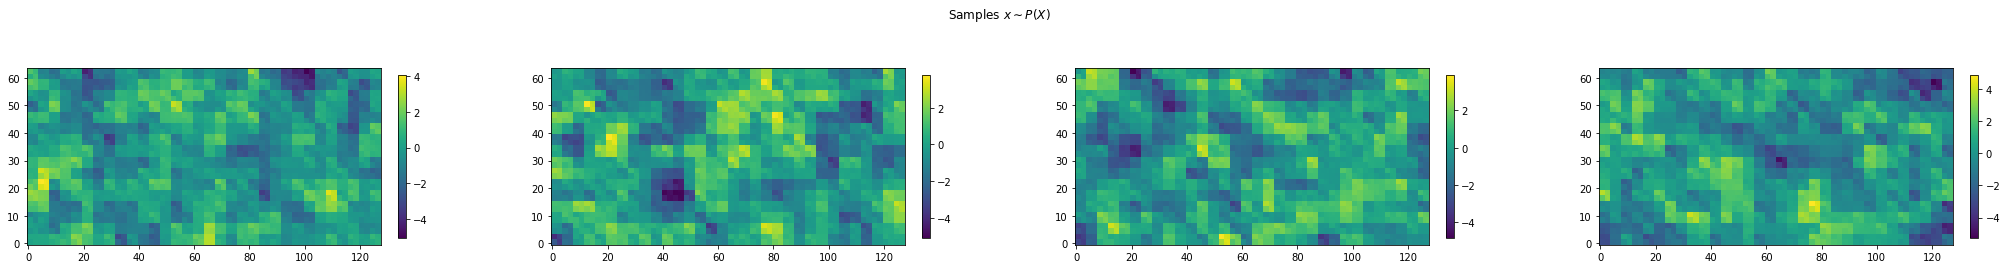

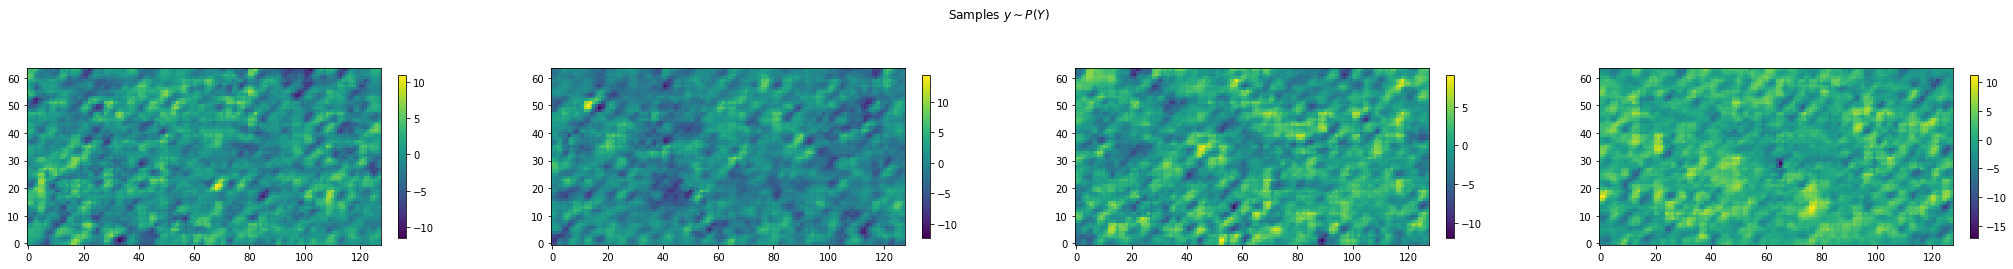

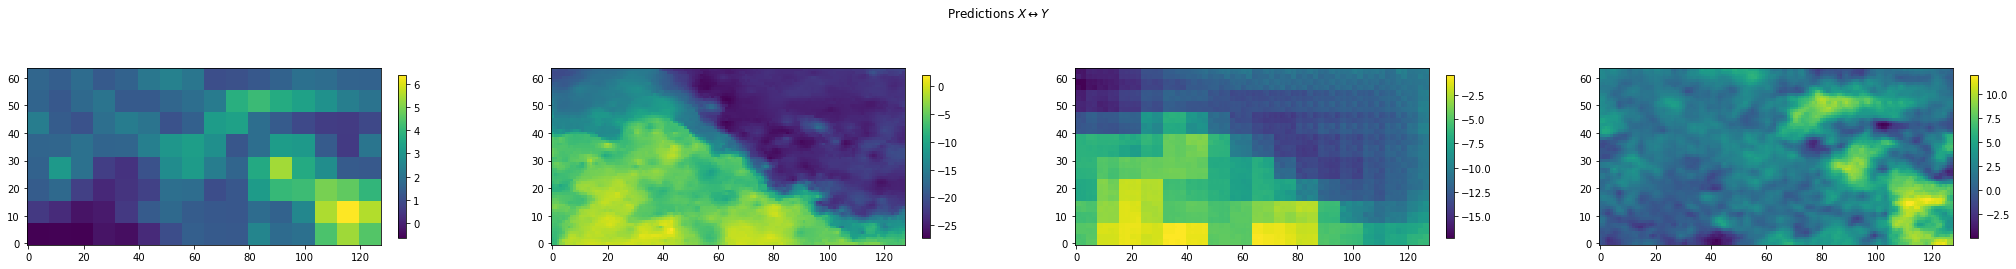

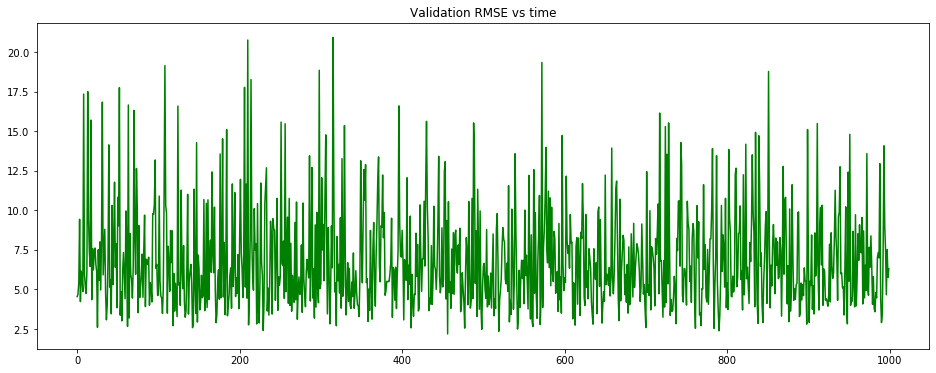

Training joint model for 10 epochs (80/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.27it/s, nll_x=-3.91, nll_y=0.48, gx_loss=-18.9, gy_loss=23.2, dx_loss=-.588, dy_loss=-.614, gx_aux=0.37, gy_aux=0.406]  


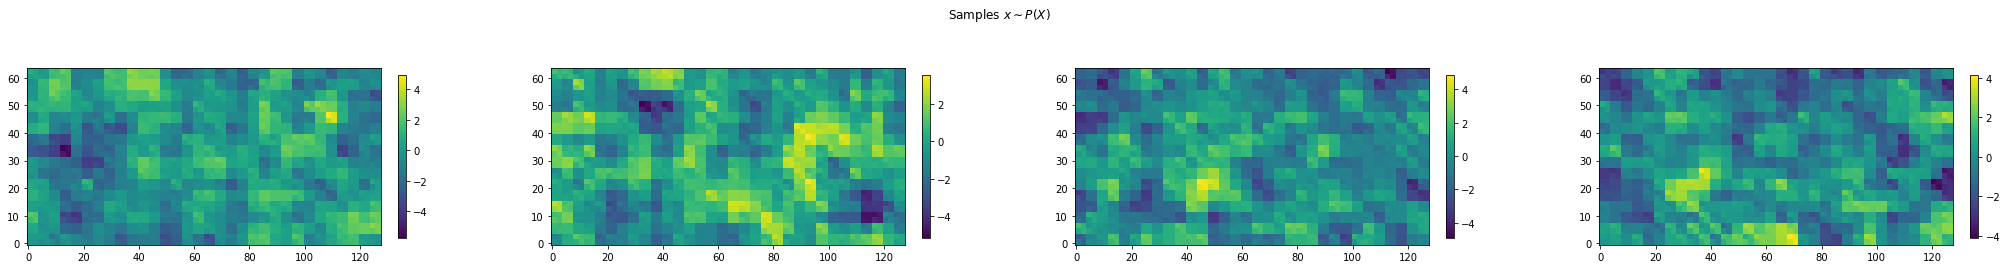

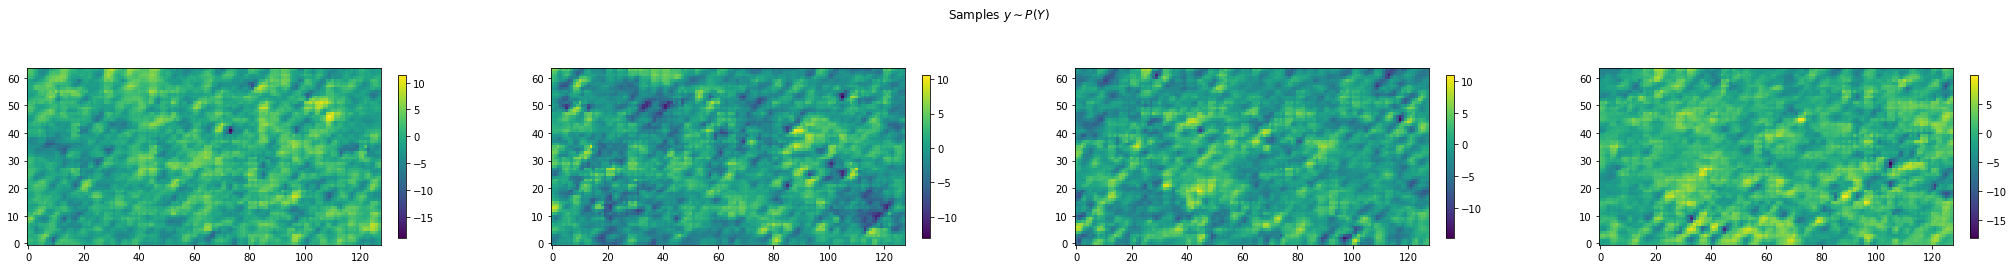

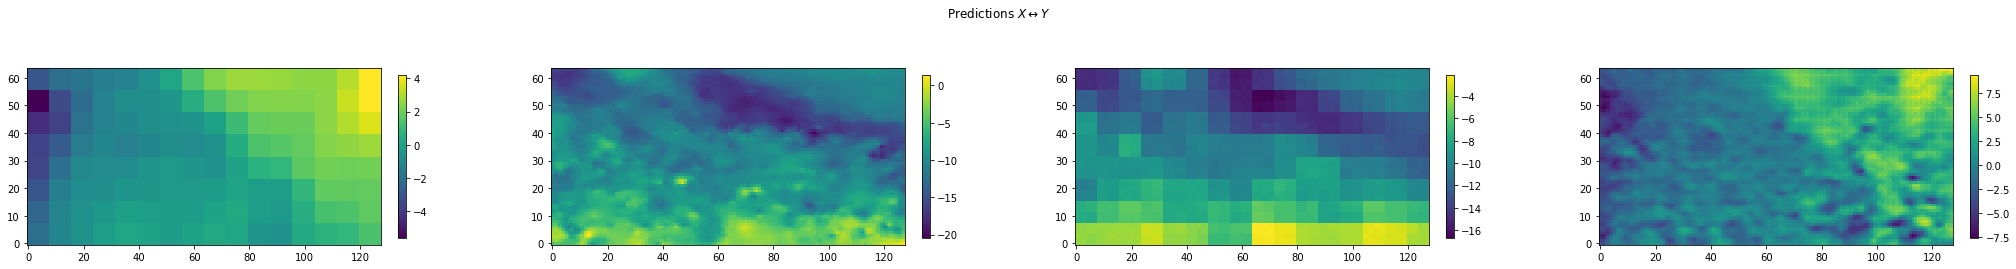

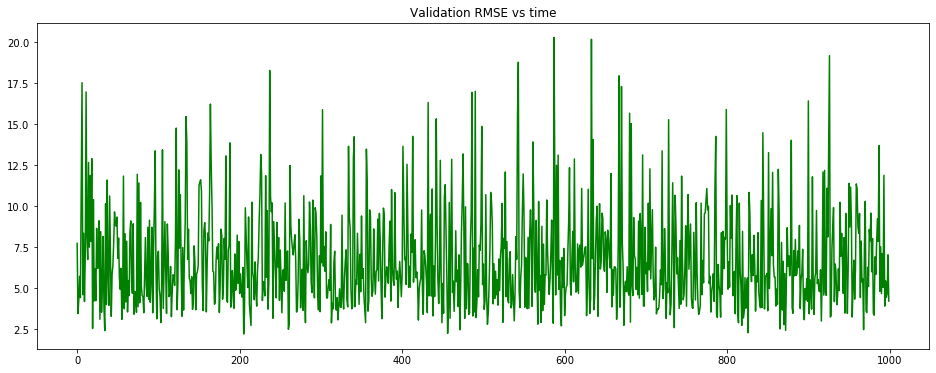

Training joint model for 10 epochs (90/100 complete)


eval: 100%|██████████| 511/511 [01:11<00:00,  7.14it/s, nll_x=-4.38, nll_y=0.453, gx_loss=-20.1, gy_loss=25.2, dx_loss=-.736, dy_loss=-.726, gx_aux=0.24, gy_aux=0.279] 


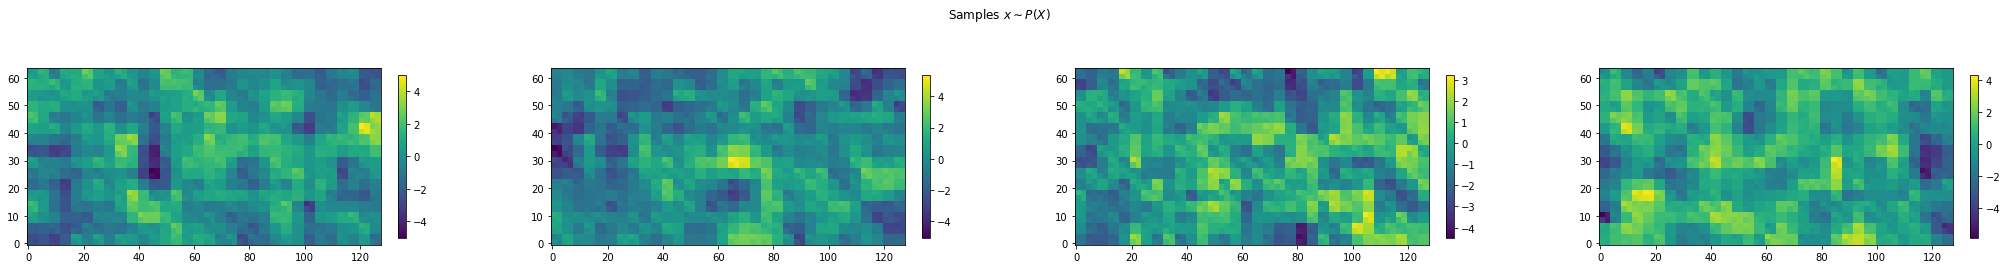

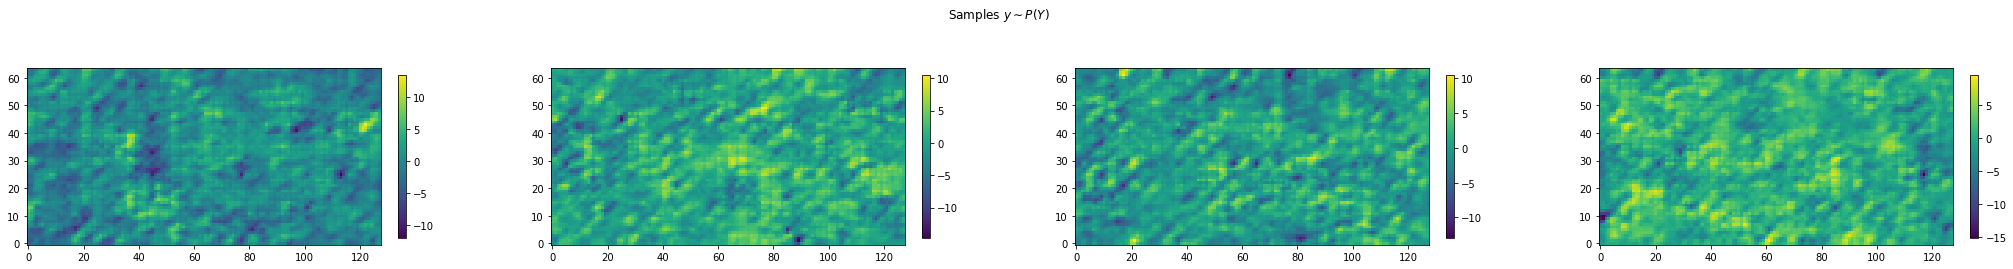

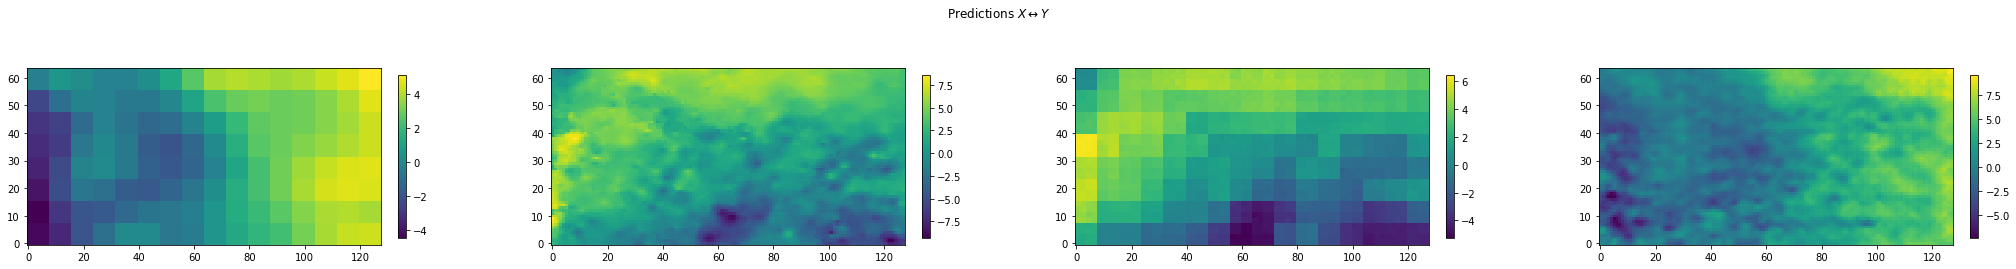

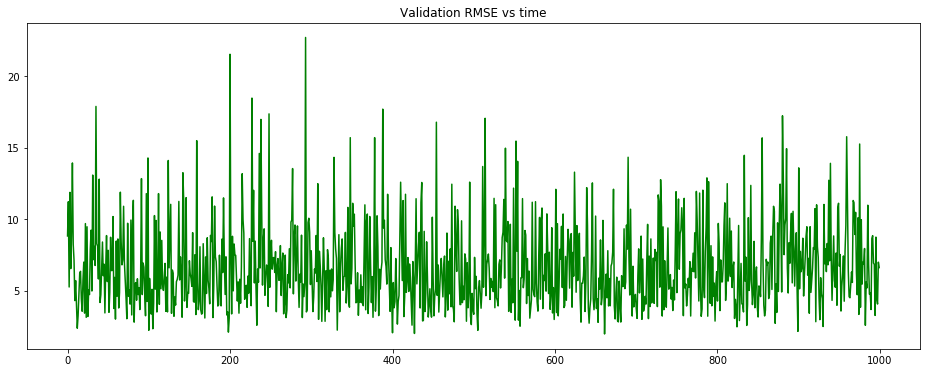

In [14]:
with mlflow.start_run() as run:
    model = fit_glow_jflvm_maxt(noaa_pnw_maxt, livneh_pnw_maxt, livneh_pnw_maxt_test, layers=4, depth=4, lam=0.1, alpha=0.0, validate_freq=10, n_epochs=100)

In [11]:
def fit_glow_jflvm_prcp(train_lr, train_hr, test_hr, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                        layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, lam_decay=0.0, alpha=1.0):
    import tensorflow_probability as tfp
    from normalizing_flows.models import JointFlowLVM, adversarial
    from normalizing_flows.flows import Transform, Flow, Invert
    from normalizing_flows.flows.image import Upsample
    from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
    train_lr = np.cbrt(train_lr)
    train_hr = np.cbrt(train_hr)
    test_hr = np.cbrt(test_hr)
    train_lr = xr.where(train_lr < 1.0, np.random.uniform(0.0, 1.0, size=(train_lr.time.size, train_lr.lat.size, train_lr.lon.size)), train_lr)
    train_hr = xr.where(train_hr < 1.0, np.random.uniform(0.0, 1.0, size=(train_hr.time.size, train_hr.lat.size, train_hr.lon.size)), train_hr)
    test_hr = xr.where(test_hr < 1.0, np.random.uniform(0.0, 1.0, size=(test_hr.time.size, test_hr.lat.size, test_hr.lon.size)), test_hr)
    train_lr = train_lr.expand_dims(chan=1, axis=-1)
    train_hr = train_hr.expand_dims(chan=1, axis=-1)
    test_hr = test_hr.expand_dims(chan=1, axis=-1)
    N_train = train_hr.shape[0]
    N_test = test_hr.shape[0]
    (wt, ht), (wt_hi, ht_hi) = train_lr.shape[1:3], train_hr.shape[1:3]
    scale = wt_hi // wt
    train_lo_ds = data_util.xr_to_tf_dataset(train_lr, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR)).shuffle(load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hr, load_batch_size).shuffle(load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hr, load_batch_size).shuffle(load_batch_size)
    train_ds = tf.data.Dataset.zip((train_lo_ds, train_hi_ds)).batch(sample_batch_size)
    test_ds = tf.data.Dataset.zip((train_lo_ds, test_hi_ds)).batch(sample_batch_size)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_hr'))
    flow_lr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_lr'))
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    prior = tfp.distributions.Logistic(loc=0.0, scale=1.0)
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy,
                               prior=prior,
                               Gx_aux_loss=spatial_mae(scale, stride=scale),
                               Gy_aux_loss=spatial_mae(scale),
                               input_shape=(None,wt_hi,ht_hi,1))
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam-lam_decay*validate_freq*i, lam_decay=lam_decay, alpha=alpha)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        model_joint.save('data/saved_models/glow-jflvm/noaa_livneh/prcp/ckpt')
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        samples_x = tf.where(samples_x > 1.0, samples_x, 0.0)
        samples_y = tf.where(samples_y > 1.0, samples_y, 0.0)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$", cmap=prcp_cmap())
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$", cmap=prcp_cmap())
        x_t, y_t = next(test_ds.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        x_t = tf.where(x_t > 1.0, x_t, 0.0)
        y_t = tf.where(y_t > 1.0, y_t, 0.0)
        xp_t = tf.where(xp_t > 1.0, xp_t, 0.0)
        yp_t = tf.where(yp_t > 1.0, yp_t, 0.0)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$", cmap=prcp_cmap())
        y_true, y_pred = [], []
        for x, y in test_ds.take(100):
            y_true.append(y)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.where(y_true > 1.0, tf.math.pow(y_true, 3.0), 0.0)
        y_pred = tf.where(y_pred > 1.0, tf.math.pow(y_pred, 3.0), 0.0)
        rmse = tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
        mlflow.log_metric('rmse', tf.math.reduce_mean(rmse).numpy())
        plt.figure(figsize=(2*8,6))
        plt.plot(range(rmse.shape[0]), rmse, c='g')
        plt.title('Validation RMSE vs time')
        plt.show()
    return model_joint

In [9]:
livneh_pnw_pr_test = preprocess_livneh(livneh16, 'pr', time_st='2000-01-01', time_en='2013-12-31')

Training joint model for 10 epochs (0/100 complete)


eval: 100%|██████████| 511/511 [01:49<00:00,  4.69it/s, nll_x=-1.35, nll_y=0.632, gx_loss=0.407, gy_loss=0.1, dx_loss=-.193, dy_loss=-.14, gx_aux=0.0284, gy_aux=0.0583]   


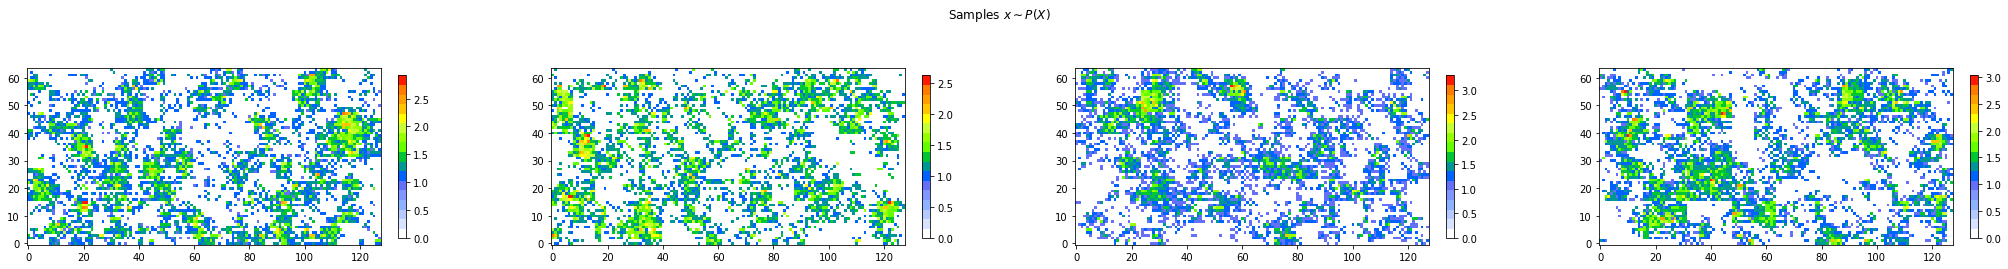

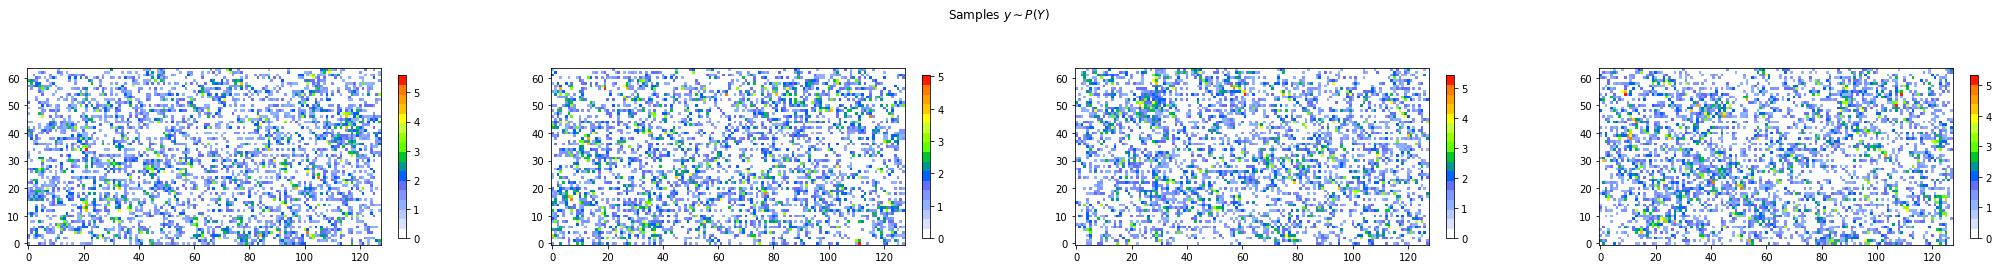

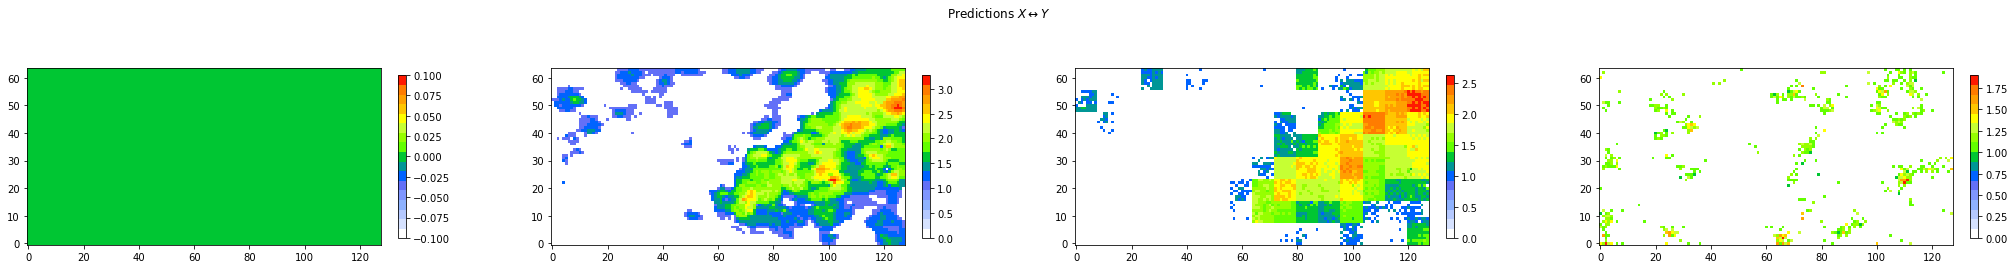

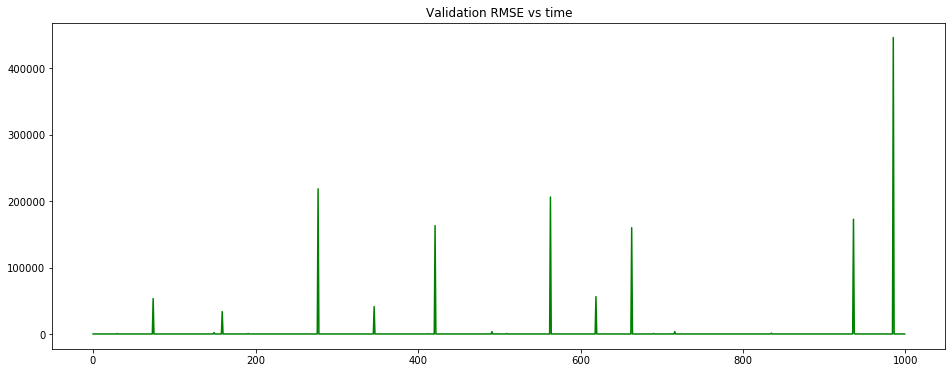

Training joint model for 10 epochs (10/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.28it/s, nll_x=-2.89, nll_y=0.363, gx_loss=0.395, gy_loss=-.0516, dx_loss=-.203, dy_loss=-.165, gx_aux=0.0245, gy_aux=0.0626]


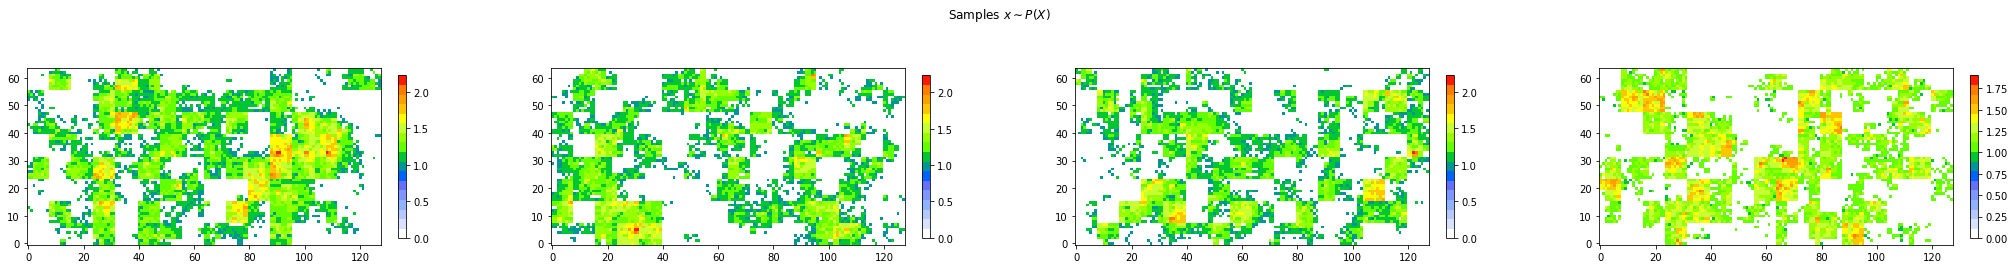

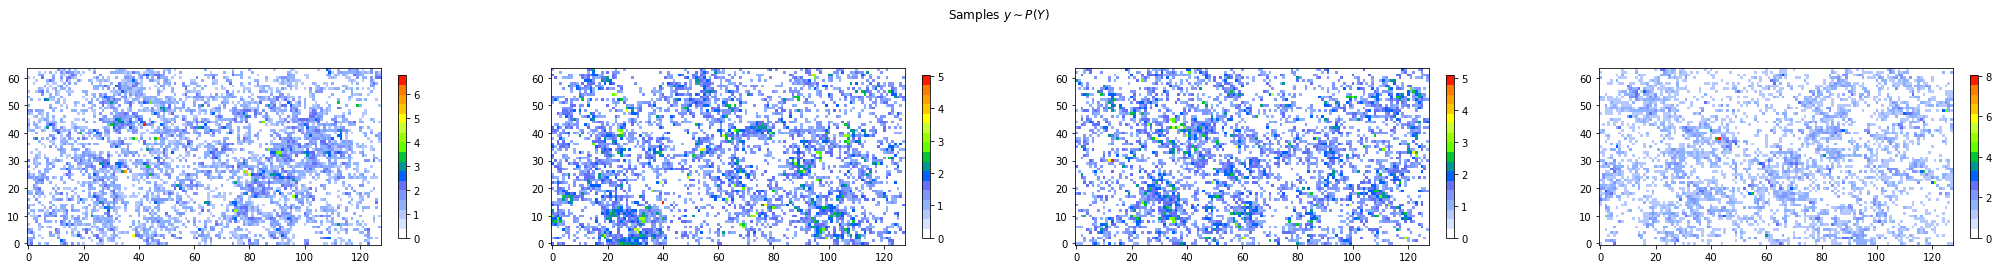

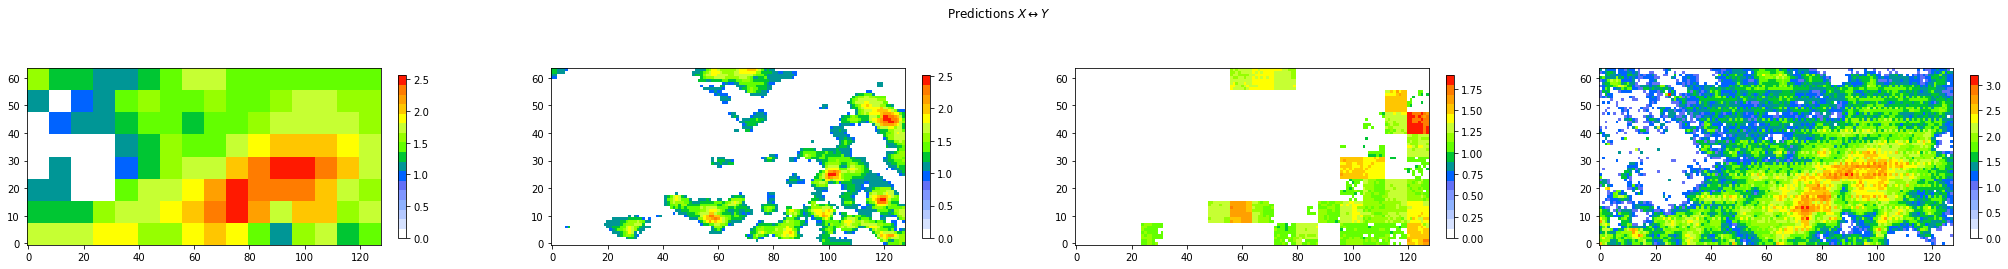

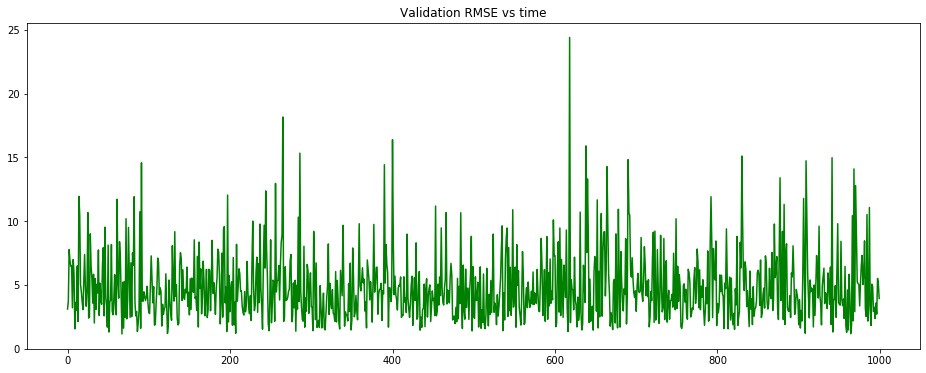

Training joint model for 10 epochs (20/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.24it/s, nll_x=-3.87, nll_y=0.223, gx_loss=0.329, gy_loss=-.0308, dx_loss=-.197, dy_loss=-.134, gx_aux=0.0314, gy_aux=0.0795]


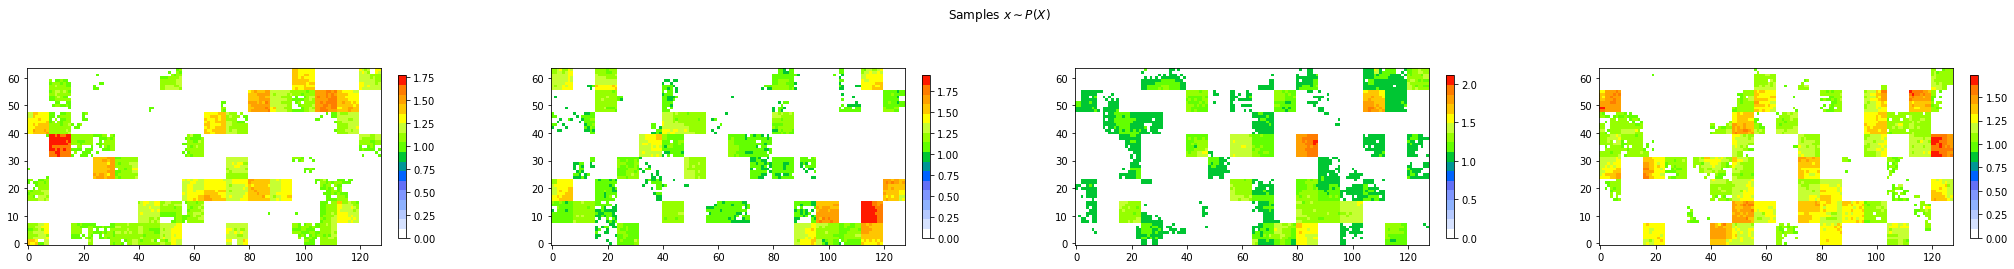

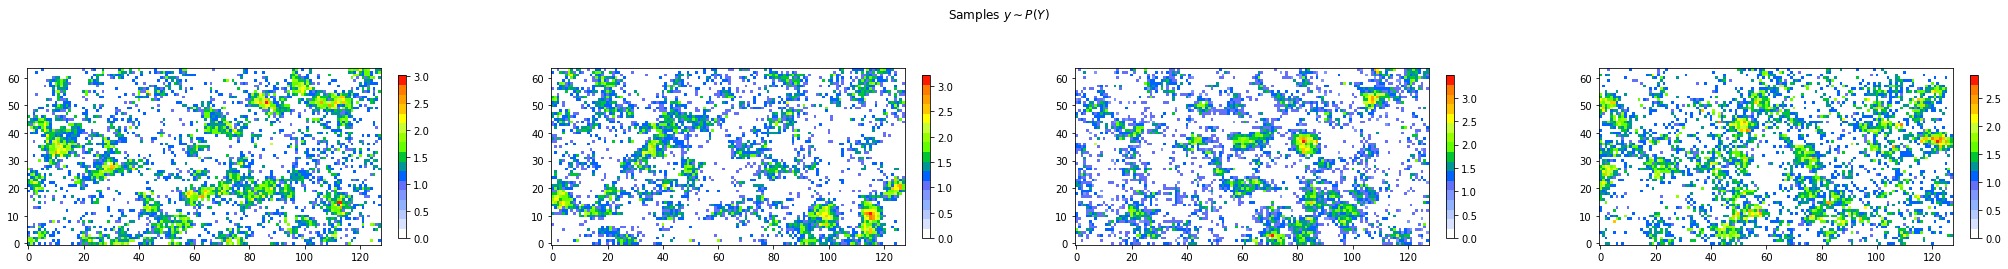

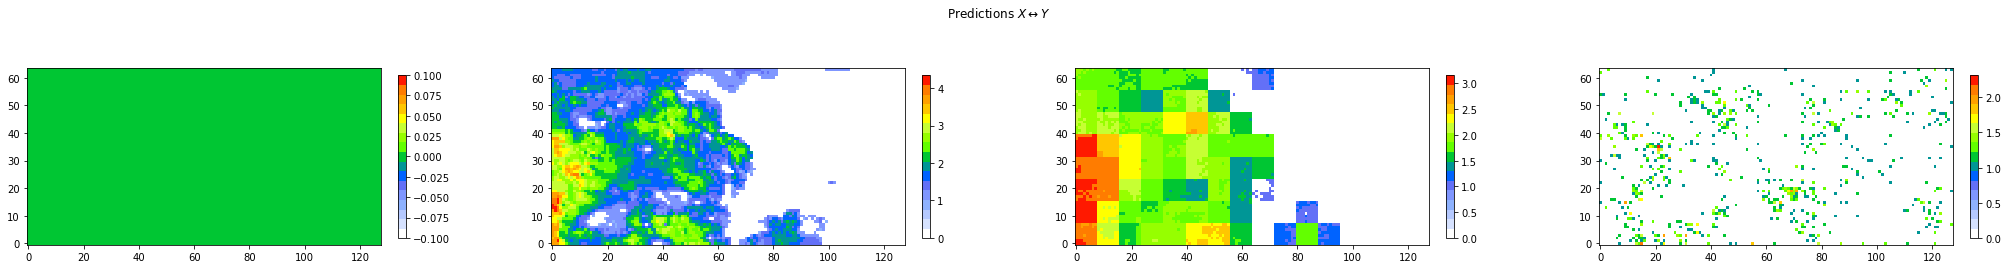

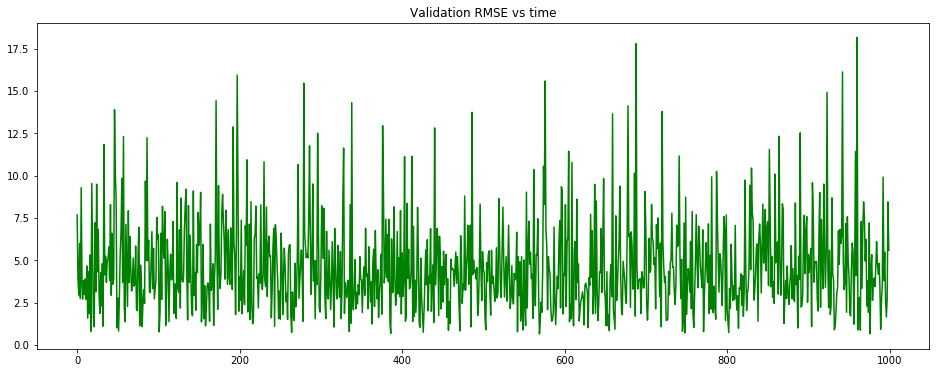

Training joint model for 10 epochs (30/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.35it/s, nll_x=-4.69, nll_y=0.166, gx_loss=0.355, gy_loss=-.0665, dx_loss=-.194, dy_loss=-.148, gx_aux=0.0285, gy_aux=0.0701]


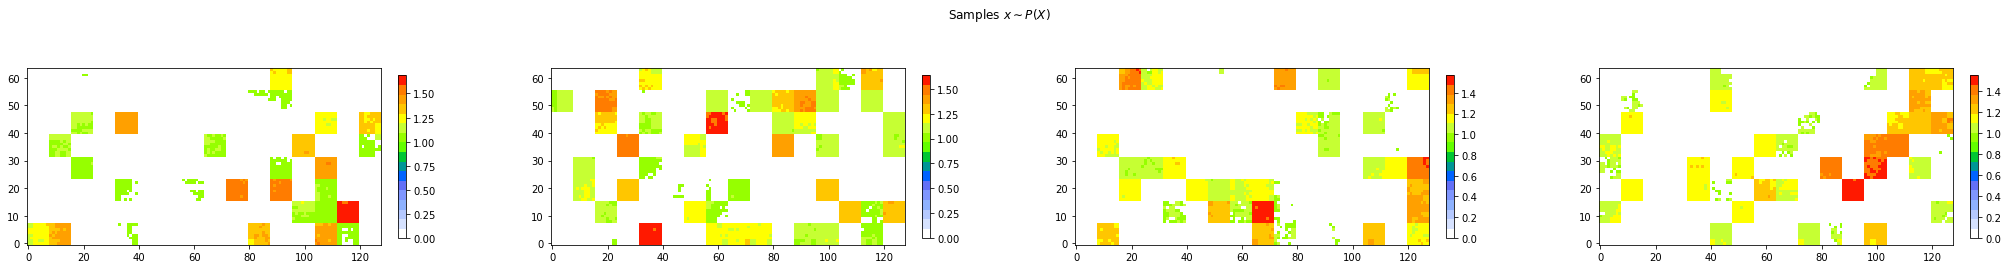

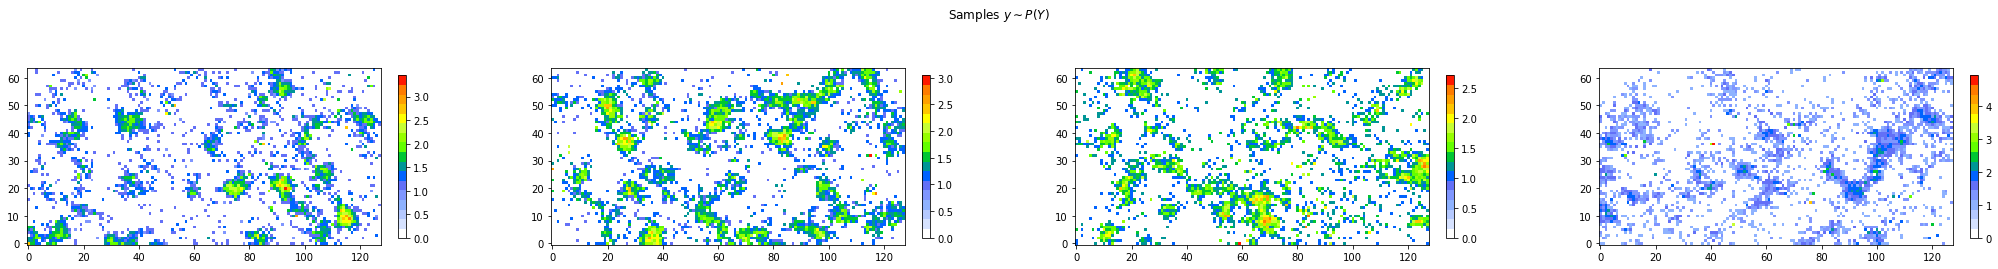

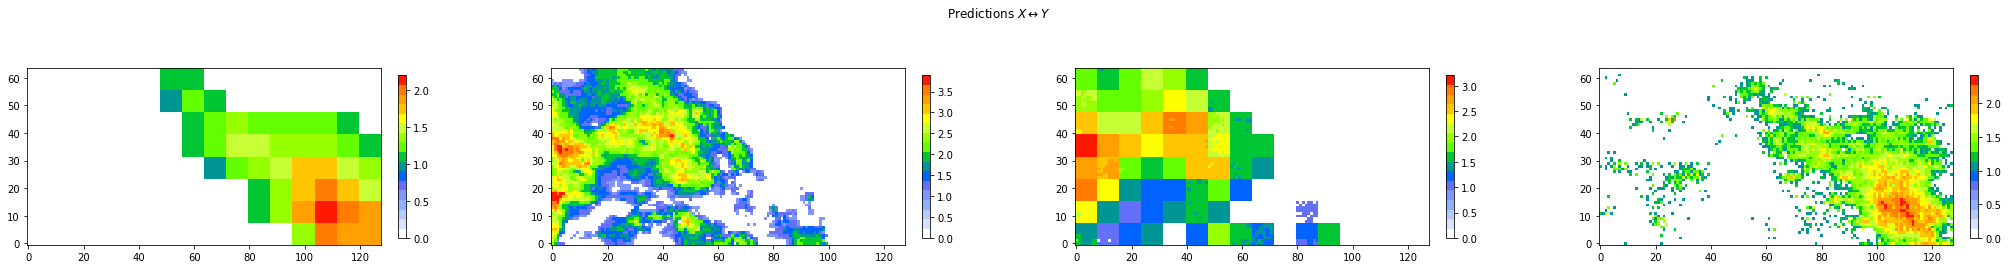

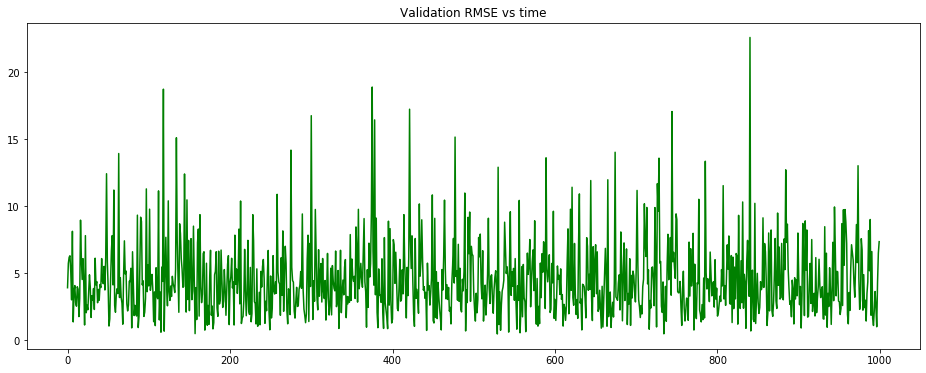

Training joint model for 10 epochs (40/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.29it/s, nll_x=-5.26, nll_y=0.146, gx_loss=0.358, gy_loss=-.0212, dx_loss=-.204, dy_loss=-.104, gx_aux=0.0266, gy_aux=0.0909]


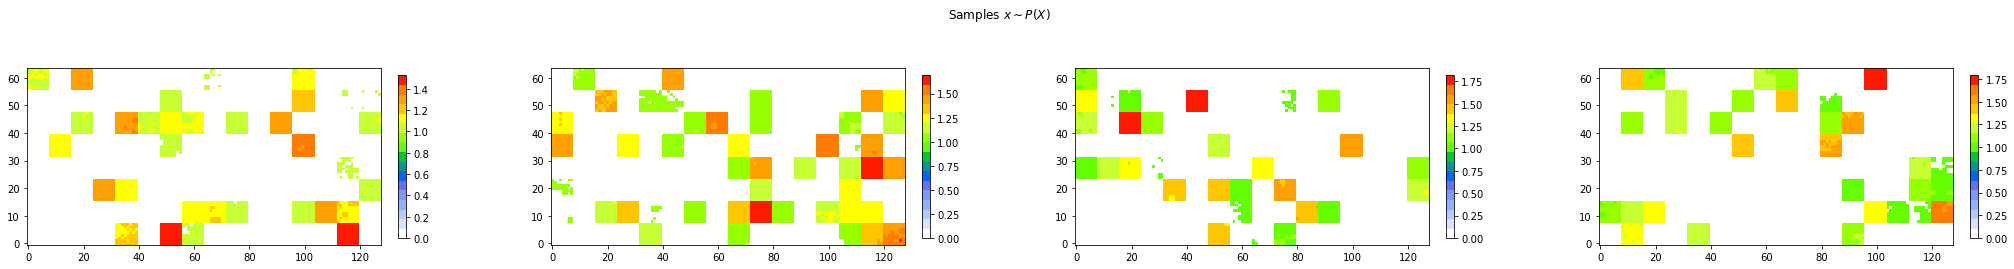

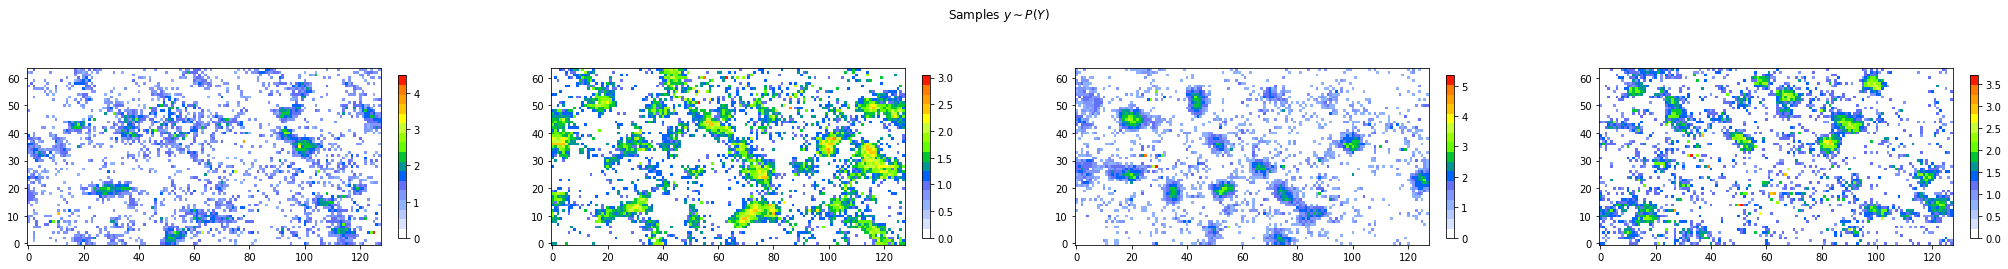

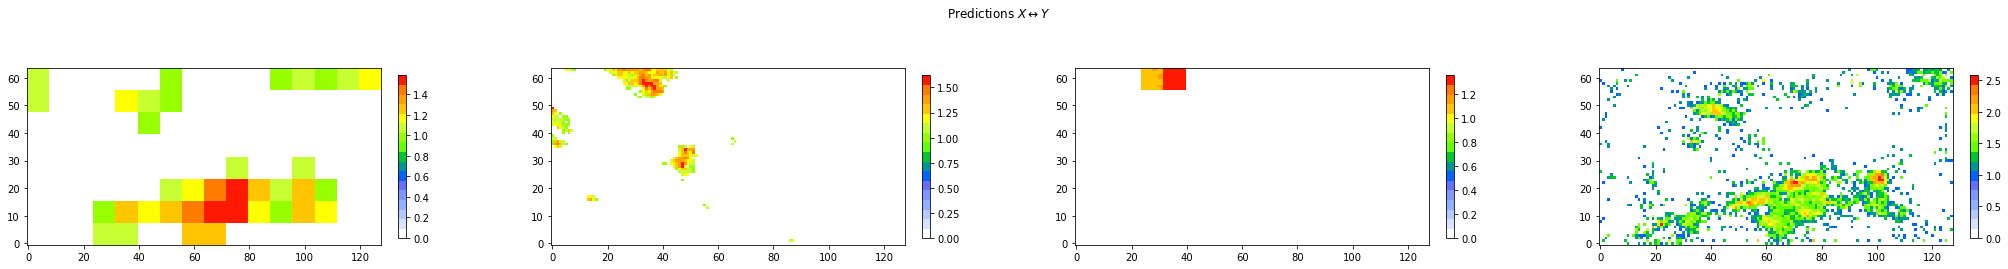

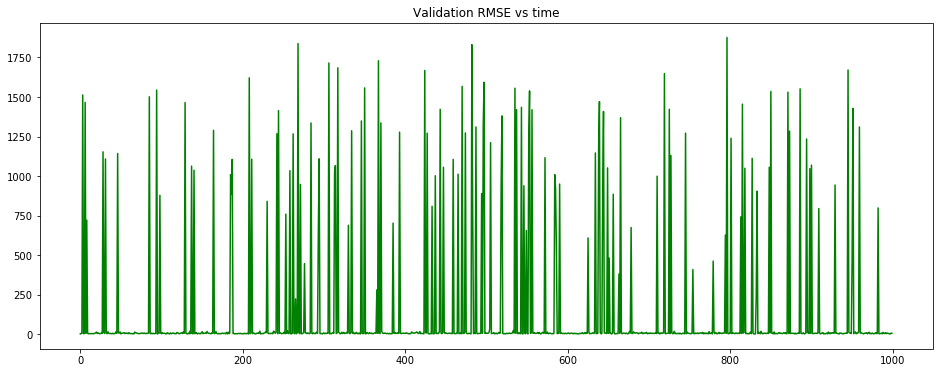

Training joint model for 10 epochs (50/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.33it/s, nll_x=-5.76, nll_y=0.122, gx_loss=0.367, gy_loss=0.0417, dx_loss=-.197, dy_loss=-.135, gx_aux=0.0311, gy_aux=0.0743]


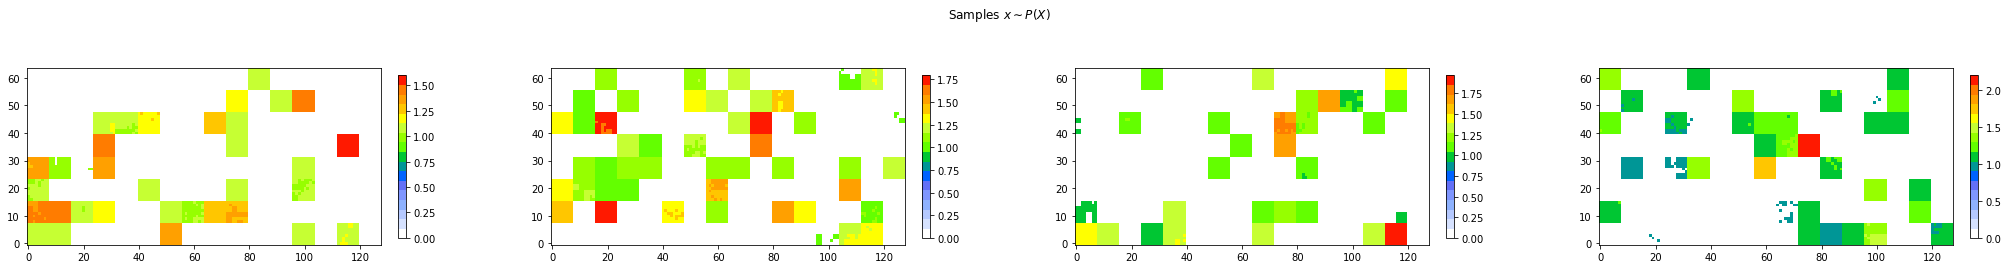

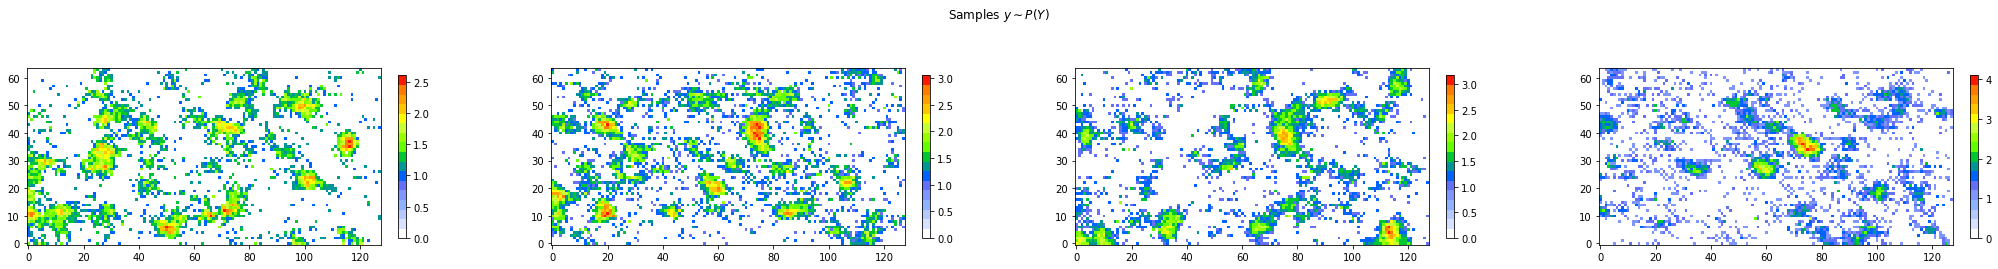

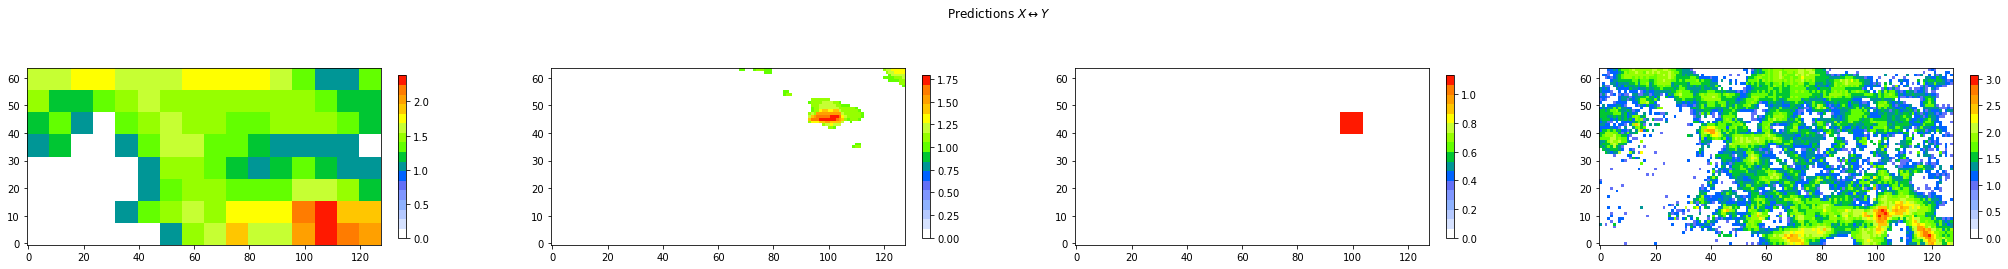

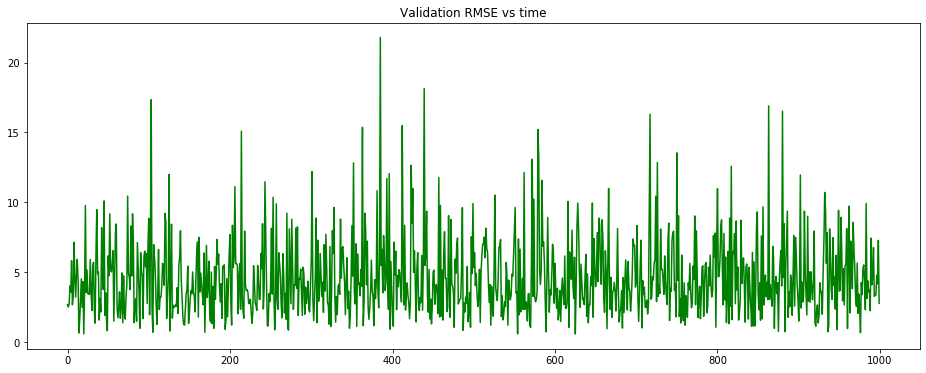

Training joint model for 10 epochs (60/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.31it/s, nll_x=-5.57, nll_y=0.106, gx_loss=0.33, gy_loss=-.00215, dx_loss=-.194, dy_loss=-.128, gx_aux=0.0436, gy_aux=0.0842] 


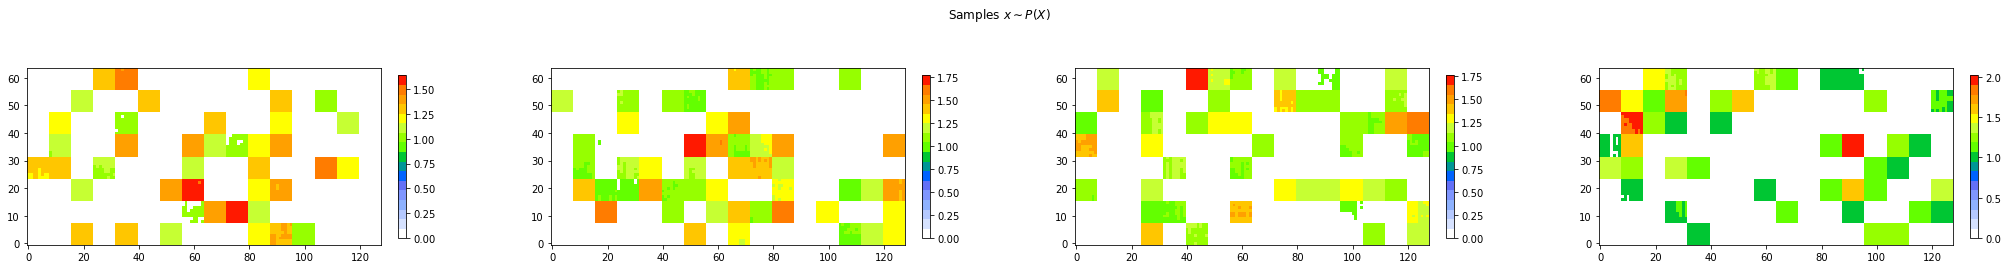

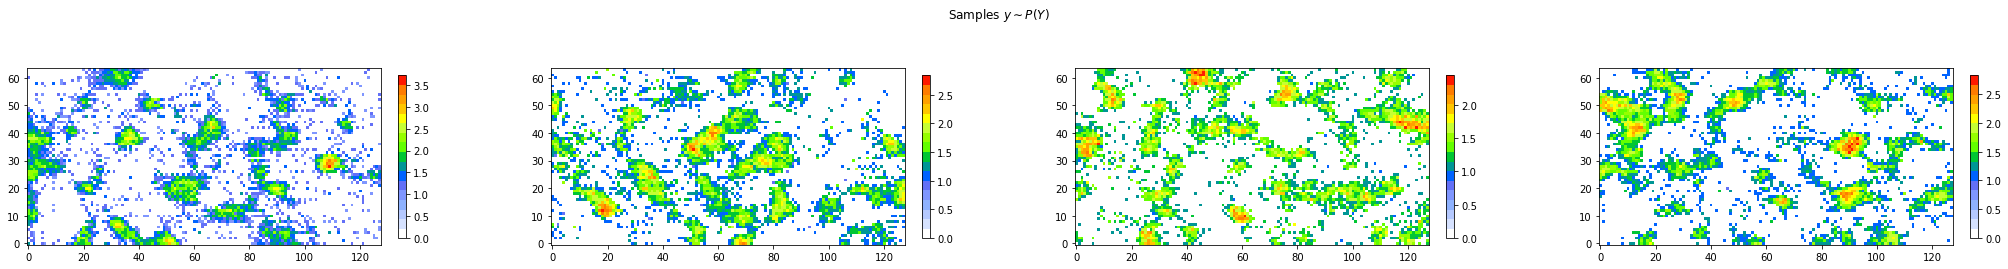

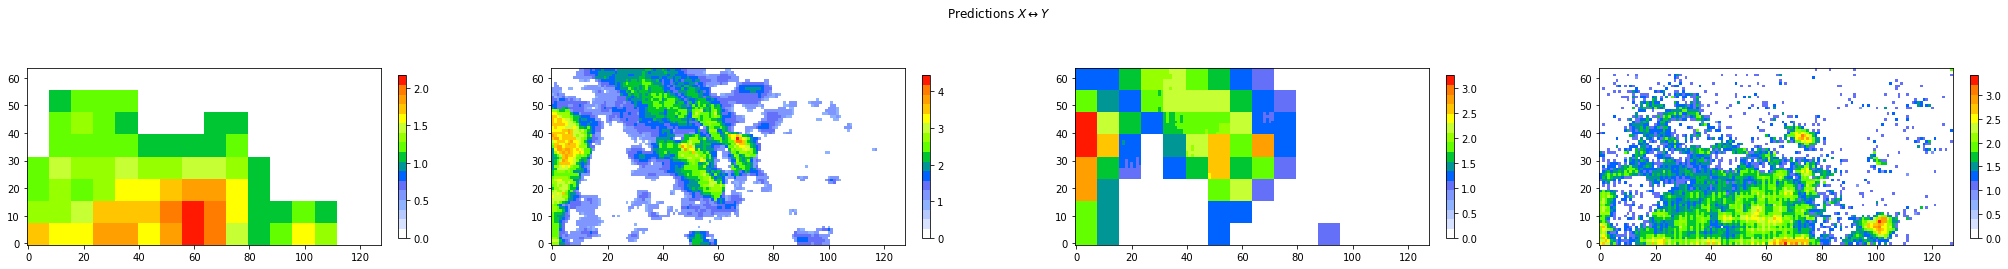

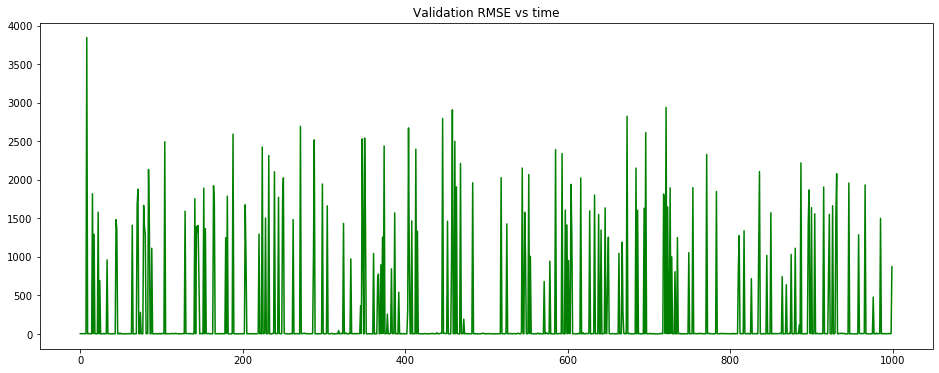

Training joint model for 10 epochs (70/100 complete)


eval: 100%|██████████| 511/511 [01:09<00:00,  7.34it/s, nll_x=-6.24, nll_y=0.0911, gx_loss=0.335, gy_loss=0.0772, dx_loss=-.199, dy_loss=-.13, gx_aux=0.0358, gy_aux=0.0909] 


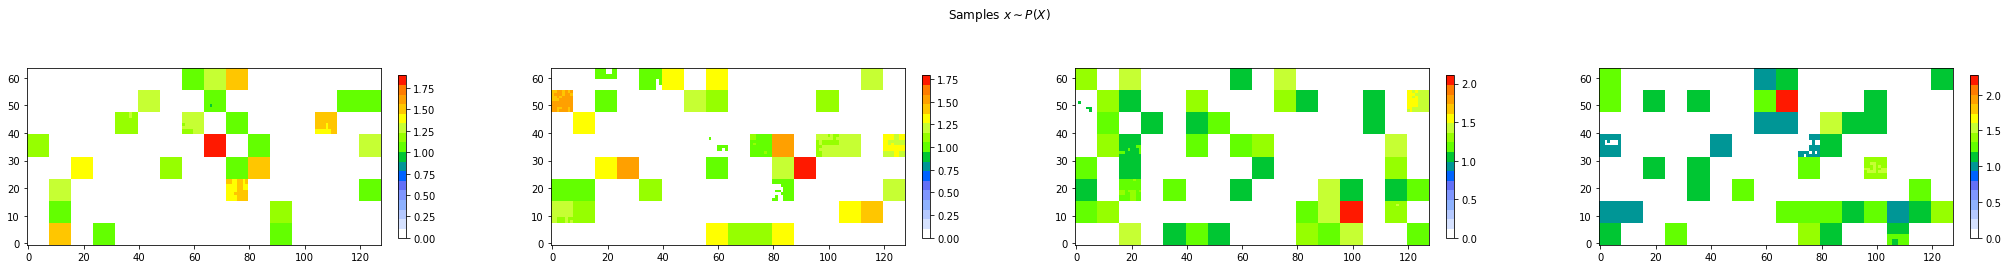

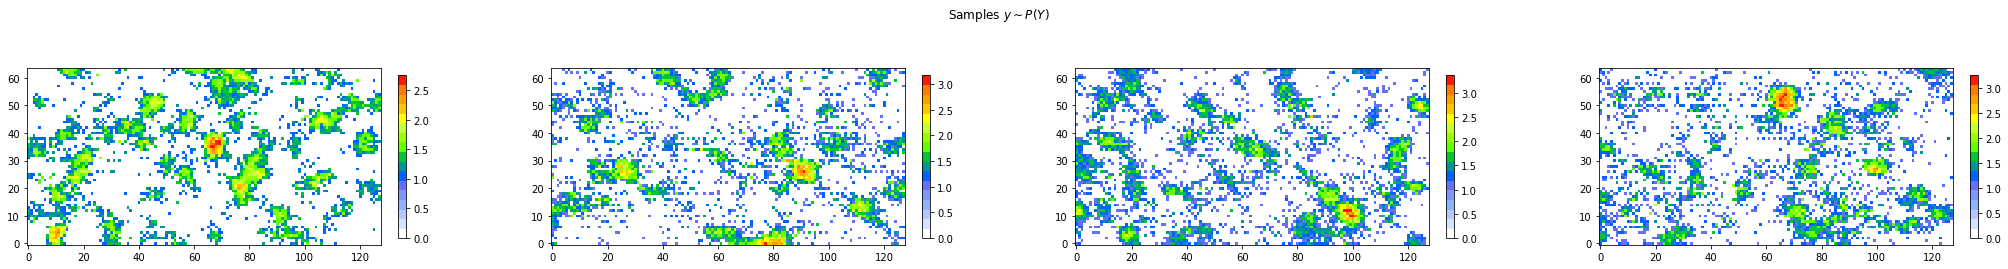

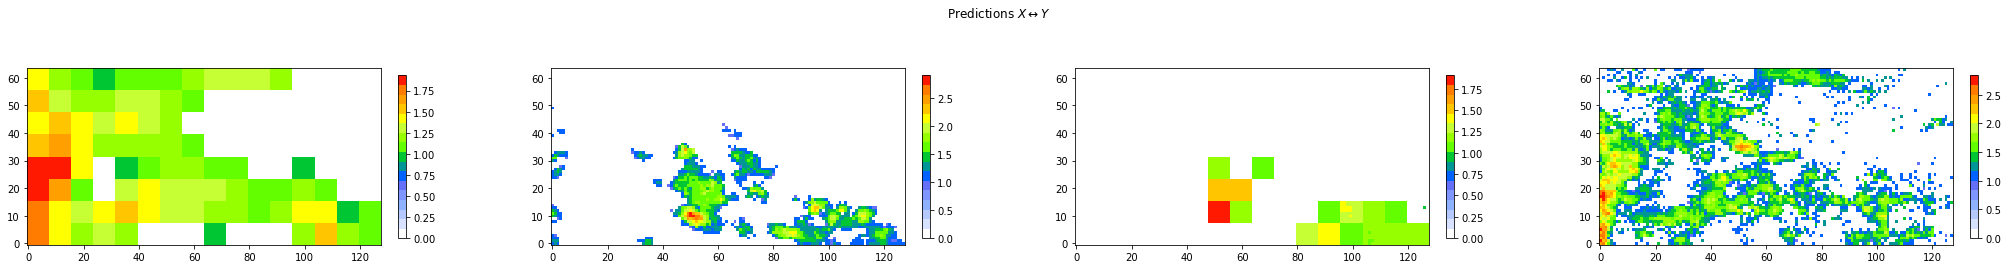

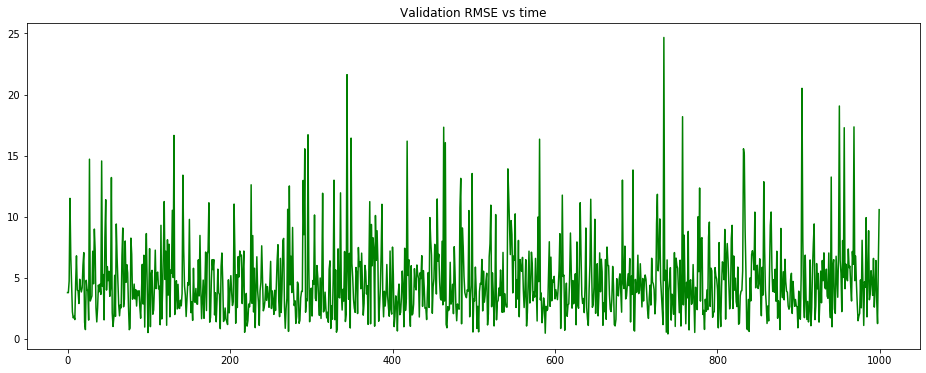

Training joint model for 10 epochs (80/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.25it/s, nll_x=-5.08, nll_y=0.0801, gx_loss=0.353, gy_loss=0.103, dx_loss=-.197, dy_loss=-.157, gx_aux=0.0459, gy_aux=0.0844] 


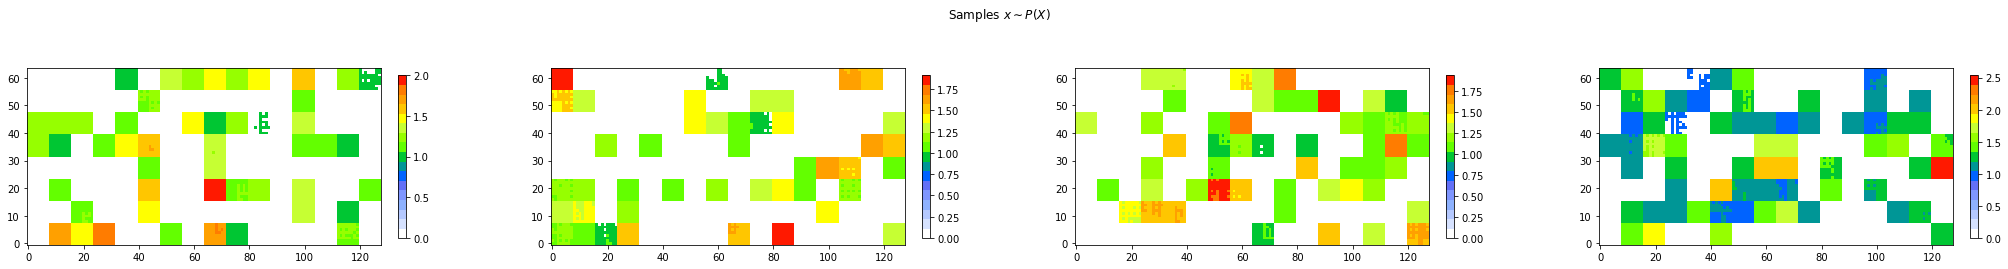

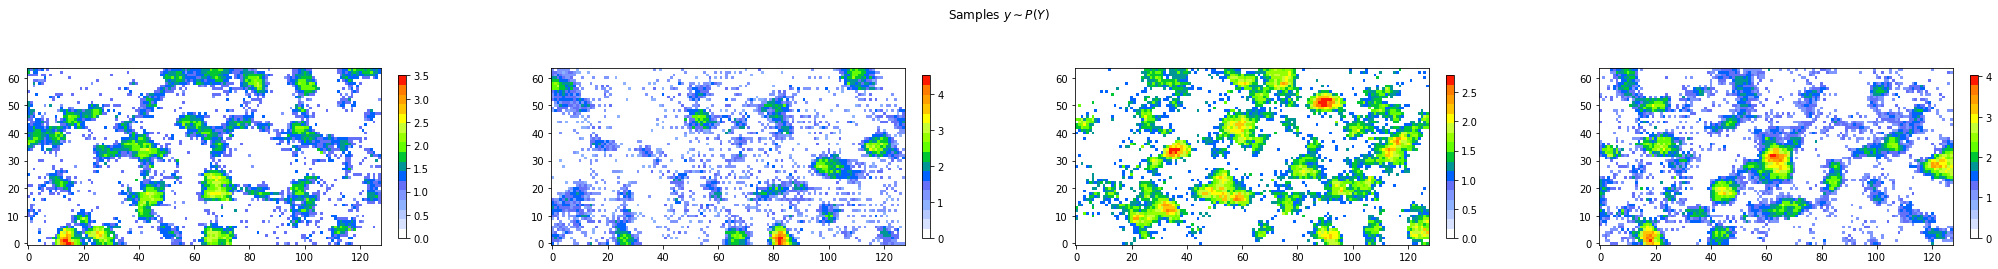

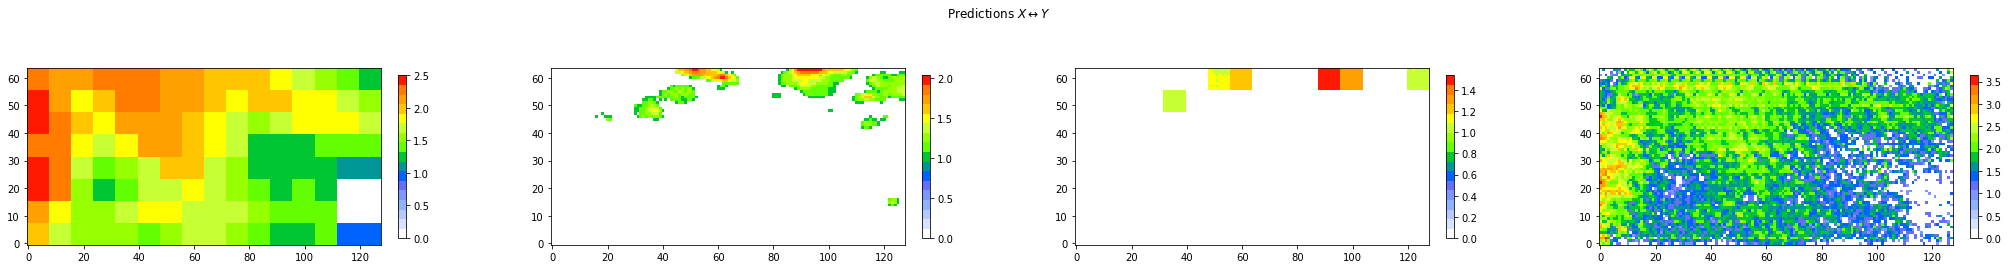

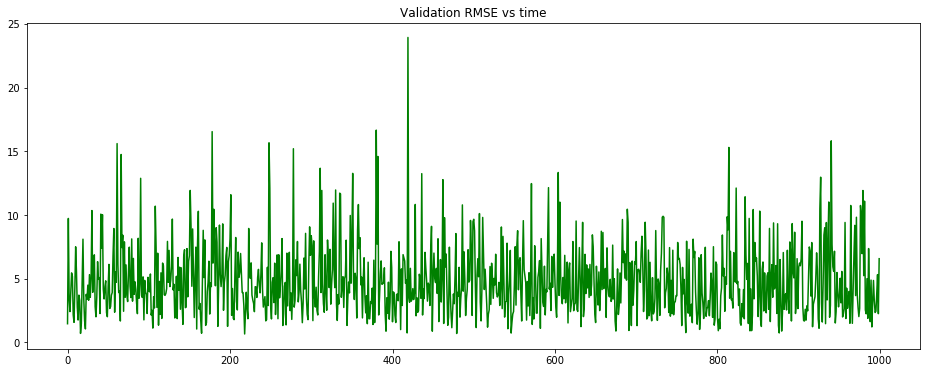

Training joint model for 10 epochs (90/100 complete)


eval: 100%|██████████| 511/511 [01:10<00:00,  7.22it/s, nll_x=-6.21, nll_y=0.0689, gx_loss=0.363, gy_loss=0.0288, dx_loss=-.197, dy_loss=-.0986, gx_aux=0.029, gy_aux=0.113] 


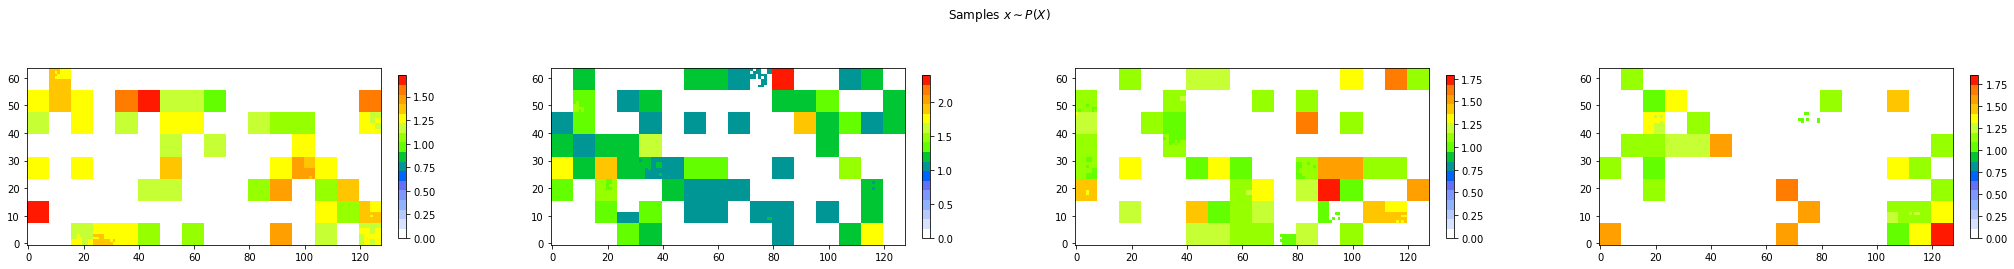

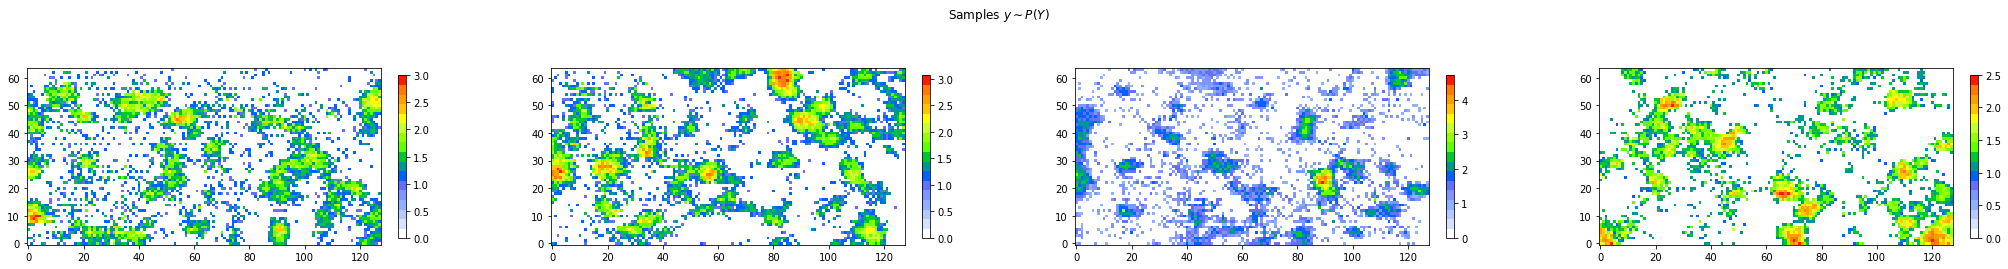

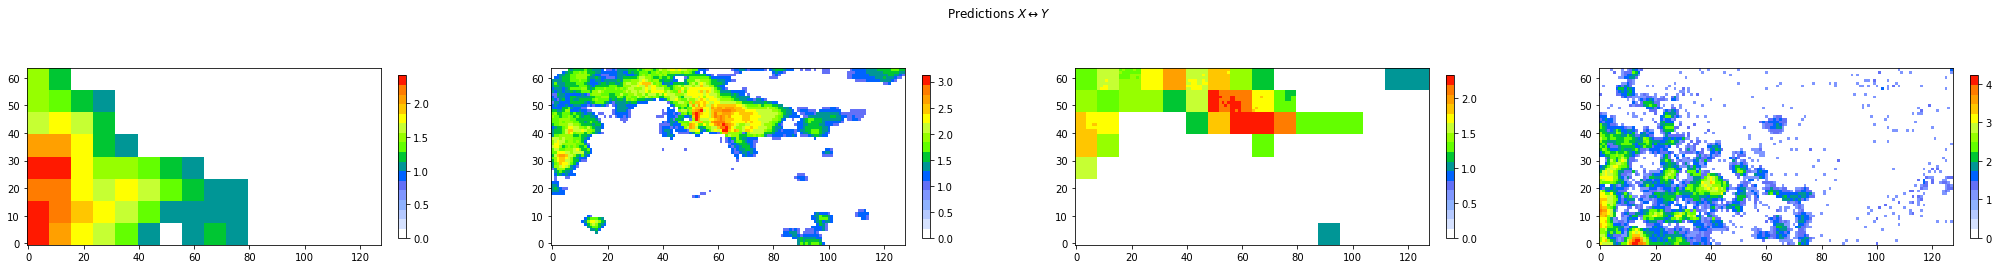

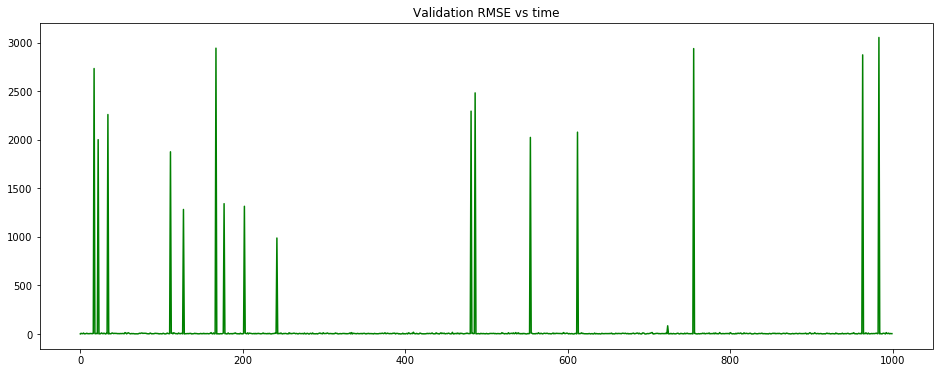

In [12]:
with mlflow.start_run() as run:
    model = fit_glow_jflvm_prcp(noaa_pnw_pr, livneh_pnw_pr, livneh_pnw_pr_test, layers=4, depth=4, lam=0.1, alpha=0.0, validate_freq=10, n_epochs=100)